In [114]:
import numpy as np
import pandas as pd
from glob import glob 
from tqdm import tqdm
import seaborn as sns 





# for converting the text file containing the quarry locations into csv file
import csv

# for computing the geographical distance between two points 
import math


from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from datetime import datetime
from sklearn.decomposition import PCA
import lightgbm as lgb
import h5py
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_iris
from scipy import stats, signal
from sklearn.preprocessing import StandardScaler
import obspy
from obspy.geodetics.base import gps2dist_azimuth, gps2dist_azimuth
from obspy.clients.fdsn import Client
import re
from sklearn.model_selection import cross_val_predict
import time
from sklearn.metrics import f1_score
pd.set_option('display.max_columns', None)
from joblib import dump, load
import concurrent.futures
from obspy.signal.filter import envelope
import tsfel


## need to append the appropriate path for the download of appropriate features
import sys
sys.path.append('../Feature_Extraction_Scripts/Physical_Feature_Extraction_Scripts')

import seis_feature
from seis_feature import compute_physical_features
from multiprocessing import Pool
from tsfel import time_series_features_extractor, get_features_by_domain
import calendar
from datetime import timedelta
from joblib import dump, load

import pickle


import os
import sys
sys.path.append('../Common_Scripts')


from common_processing_functions import apply_cosine_taper
from common_processing_functions import butterworth_filter

from zenodo_get import zenodo_get

## Loading and combining Features

### Downloading tsfel features

In [115]:
## Downloading the physical features 
## This is doi for physical features (for both 50s and 150s) - 10.5281/zenodo.10689585
## This is doi for tsfel features of 50s window length - 10.5281/zenodo.10689673
## This is doi for tsfel features of 150s window length - 10.5281/zenodo.10689824

doi = '10.5281/zenodo.10689824'  #Downloading tsfel features for 150s length
# Download files from the Zenodo record
files = zenodo_get([doi])

Title: Tsfel Features for my study on Automatic Seismic Event Classification System in Pacific Northwest (150s)
Keywords: 
Publication date: 2024-02-21
DOI: 10.5281/zenodo.10689824
Total size: 1483.0 MB

Link: https://zenodo.org/record/10689824/files/tsfel_features_comcat_z_earthquake_50_100_part3.csv   size: 411.4 MB
tsfel_features_comcat_z_earthquake_50_100_part3.csv is already downloaded correctly.

Link: https://zenodo.org/record/10689824/files/tsfel_features_comcat_z_earthquake_50_100_part2.csv   size: 295.7 MB
tsfel_features_comcat_z_earthquake_50_100_part2.csv is already downloaded correctly.

Link: https://zenodo.org/record/10689824/files/tsfel_features_comcat_z_explosion_50_100.csv   size: 96.9 MB
tsfel_features_comcat_z_explosion_50_100.csv is already downloaded correctly.

Link: https://zenodo.org/record/10689824/files/tsfel_features_noise_50_100.csv   size: 314.8 MB
tsfel_features_noise_50_100.csv is already downloaded correctly.

Link: https://zenodo.org/record/10689824/fi

### Loading tsfel features

In [118]:
# These waveforms are filtered between 1-10 Hz
# extracting features of surface events, thunder and sonic booms
features_exotic_tsfel = pd.read_csv('tsfel_features_exotic_50_100.csv')




# features of noise
features_noise_tsfel = pd.read_csv('tsfel_features_noise_50_100.csv')





# features of explosion
features_explosion_tsfel = pd.read_csv('tsfel_features_comcat_z_explosion_50_100.csv')



# features of earthquake (had to extract it in three parts because of memory constraints)
features_eq1 = pd.read_csv('tsfel_features_comcat_z_earthquake_50_100_part1.csv')
features_eq2 = pd.read_csv('tsfel_features_comcat_z_earthquake_50_100_part2.csv')
features_eq3 = pd.read_csv('tsfel_features_comcat_z_earthquake_50_100_part3.csv')



# features of earthquakes
features_earthquake_tsfel = pd.concat([features_eq1, features_eq2, features_eq3])

## There are a total of 390 columns that contain tsfel features

## Note that each dataframe contains three additional columns - 

-  the initial unnamed 0 column, not sure why it is there. 
- The 'serial_no' column this was added to identify the similar event to alllow merging of tsfel and physical features. Each event is associated with unique serial number. 
- The serial no. is equal to the iteration number when looping through the catalog of specific source type. 
- Third column added was the 'source'

### Downloading physical features

In [119]:
## Downloading the physical features 
## This is doi for physical features (for both 50s and 150s) - 10.5281/zenodo.10689585
## This is doi for tsfel features of 50s window length - 10.5281/zenodo.10689673
## This is doi for tsfel features of 150s window length - 10.5281/zenodo.10689824

doi = '10.5281/zenodo.10689585'  #Downloading physical
# Download files from the Zenodo record
files = zenodo_get([doi])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



### Loading physical features

In [120]:
# extracting features of surface events, thunder and sonic booms
features_exotic_physical = pd.read_csv('physical_features_exotic_z_50_100.csv')

# features of noise
features_noise_physical = pd.read_csv('physical_features_noise_z_50_100.csv')


# features of explosion
features_explosion_physical = pd.read_csv('physical_features_comcat_z_explosion_50_100.csv')

# features of earthquakes
features_eq1 = pd.read_csv('physical_features_comcat_z_earthquake_50_100_part1.csv')
features_eq2 = pd.read_csv('physical_features_comcat_z_earthquake_50_100_part2.csv')
features_eq3 = pd.read_csv('physical_features_comcat_z_earthquake_50_100_part3.csv')
features_eq4 = pd.read_csv('physical_features_comcat_z_earthquake_50_100_part4.csv')

features_earthquake_physical = pd.concat([features_eq1, features_eq2, features_eq3, features_eq4])








## Deleting the directory

In [6]:
# Get the current working directory
directory = os.getcwd()

# List the files in the directory
files = os.listdir(directory)

# Iterate over the files and delete CSV files
for file in files:
    if file.endswith(".csv"):
        file_path = os.path.join(directory, file)
        os.remove(file_path)

## There are total of 62 engineered/physical features

## Merging tsfel + physical features

In [121]:
features_noise = pd.merge(features_noise_physical, features_noise_tsfel, on = 'serial_no')
features_earthquake = pd.merge(features_earthquake_physical, features_earthquake_tsfel, on = 'serial_no')
features_explosion = pd.merge(features_explosion_physical, features_explosion_tsfel, on = 'serial_no')


features_surface_tsfel = features_exotic_tsfel[features_exotic_tsfel['source'] == 'surface']
features_sonic_tsfel = features_exotic_tsfel[features_exotic_tsfel['source'] == 'sonic']
features_thunder_tsfel = features_exotic_tsfel[features_exotic_tsfel['source'] == 'thunder']

features_surface_physical = features_exotic_physical[features_exotic_physical['source'] == 'surface']
features_sonic_physical = features_exotic_physical[features_exotic_physical['source'] == 'sonic']
features_thunder_physical = features_exotic_physical[features_exotic_physical['source'] == 'thunder']


features_surface = pd.merge(features_surface_physical, features_surface_tsfel, on = 'serial_no')
features_sonic = pd.merge(features_sonic_physical, features_sonic_tsfel, on = 'serial_no')
features_thunder = pd.merge(features_thunder_physical, features_thunder_tsfel, on = 'serial_no')



features_all = pd.concat([features_surface, features_sonic, features_thunder, features_noise, features_explosion, features_earthquake])

In [122]:
features_all

Unnamed: 0_x  Window_Length  RappMaxMean  RappMaxMedian     AsDec  \
0                  0         149.99    17.776003     175.103428  0.709677   
1                  0         149.99    21.241261      58.465352  0.621338   
2                  0         149.99    27.725473      80.883406  0.577846   
3                  0         149.99    19.966025     222.727489  0.646975   
4                  0         149.99    20.533904      85.900970  0.648242   
...              ...            ...          ...            ...       ...   
164435             0         149.99    30.841548      87.995700  0.534582   
164436             0         149.99    39.016950      72.920787  0.553817   
164437             0         149.99    26.857458      42.487335  0.627496   
164438             0         149.99    11.900798      16.833994  0.578178   
164439             0         149.99    66.029804     135.328391  0.642646   

          KurtoSig    KurtoEnv   SkewSig    SkewEnv  CorPeakNumber  \
0        23.501216   16.006836  0.356660   3.399238          579.0   
1        31.182369   20.761347 -0.055231   4.309129          815.0   
2        40.820013   27.889707  0.322008   4.876178          783.0   
3        29.335914   18.888127 -0.071831   4.090228          591.0   
4        30.269270   20.426779  0.775952   4.110190          945.0   
...            ...         ...       ...        ...            ...   
164435   42.592345   30.935670 -0.815543   4.869022          999.0   
164436  111.387312   84.507240  1.011052   7.864319         1135.0   
164437   61.618481   61.591317  0.590841   6.629477          987.0   
164438   16.442500   18.522292 -0.359924   3.690436         1191.0   
164439  236.374349  179.868015 -2.177095  11.559161         1037.0   

        Energy1/3Cor  Energy2/3Cor  int_ratio        E_0.1_1     E_1_3  \
0          -1.872064     -4.246410   0.440858  3.515310e+257  0.759664   
1           3.785214     -1.224495  -3.091244   0.000000e+00  0.470266   
2           2.104656     -0.522485  -4.028162  5.928788e-323  0.480161   
3           1.058208     -1.944227  -0.544282  5.928788e-323  0.652945   
4           6.898389     -9.243610  -0.746287  5.928788e-323  0.410290   
...              ...           ...        ...            ...       ...   
164435     -1.288963      1.548210  -0.832550  5.928788e-323 -0.108256   
164436      0.834769     -1.927827  -0.433010  5.928788e-323  0.361916   
164437    -15.358608     -3.036189   5.058516  5.928788e-323  0.614465   
164438      8.024956    -13.721120  -0.584862  5.928788e-323  0.669752   
164439      0.780280     -0.241503  -3.230936  5.928788e-323  0.067553   

          E_3_10   E_10_20        E_20_50     Kurt_0.1_1   Kurt_1_3  \
0       0.844353 -0.200475  1.382268e-310  9.332636e-300  21.443010   
1       0.805251  0.048987   0.000000e+00   0.000000e+00  24.024384   
2       0.637011 -0.130959  7.905050e-323  8.399116e-323  31.062972   
3       0.812782 -0.189140  7.905050e-323  8.399116e-323  32.062385   
4       0.841715  0.278259  7.905050e-323  8.399116e-323  21.334858   
...          ...       ...            ...            ...        ...   
164435  0.685416  0.239354  7.905050e-323  8.399116e-323  41.422461   
164436  0.356431  0.068110  7.905050e-323  8.399116e-323  36.333535   
164437  0.542516  0.178512  7.905050e-323  8.399116e-323  33.976977   
164438  1.037566  0.679337  7.905050e-323  8.399116e-323  10.075732   
164439  0.300575 -0.172866  7.905050e-323  8.399116e-323  43.547332   

         Kurt_3_10  Kurt_10_20     Kurt_20_50  RMSDecPhaseLine   MeanFFT  \
0        23.147926   21.544450  4.787190e+180         0.542241  3.380160   
1        34.081095   35.746622   0.000000e+00         0.487940  3.434010   
2        40.868885   44.181180  1.037538e-322         0.493914  2.908458   
3        26.782040   15.115223  1.037538e-322         0.520499  3.199676   
4        31.008198   30.427054  1.037538e-322         0.519589  4.011686   
...            ...         ...            ..

##  So there should be 454 columns (390 tsfel + 62 physical +1 source + 1serial no.) so we need to drop all other columns 

In [123]:
features_all = features_all.drop(['Unnamed: 0_x','Unnamed: 0_y', 'source_x'], axis = 1)
features_all.rename(columns={'source_y': 'source'}, inplace=True)
print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')

So we have 240898 events and each event have 454 features


## Preprocessing the input features

In [124]:
# dropping the columns that contain NaNs
features_all = features_all.dropna(axis = 1)

# dropping the rows that contains NaNs
features_all = features_all.dropna()


## dropping all the rows containing infinity values
features_all = features_all.replace([np.inf, -np.inf], np.nan).dropna()


## dropping sonic boom and thunder events
features_all = features_all[features_all['source'] != 'sonic']
features_all = features_all[features_all['source'] != 'thunder']

print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')


So we have 240543 events and each event have 453 features


## Dropping the columns that contain same values for all the events, as these features do not really contribute in classification

In [125]:
# Check unique values in each column
unique_counts = features_all.nunique()

# Identify columns with only one unique value (same value for all rows)
single_value_columns = unique_counts[unique_counts == 1].index


# Drop columns with the same value for all rows
features_all = features_all.drop(columns=single_value_columns)

print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')


So we have 240543 events and each event have 439 features


## Data Cleaning

### Removing the outliers

In [126]:
df = features_all.drop(['serial_no', 'source'], axis = 1)
# Calculate Z-scores for each feature
z_scores = np.abs(stats.zscore(df))


# Define a threshold for Z-score beyond which data points are considered outliers
threshold = 4

# Filter out rows with any Z-score greater than the threshold
# Temporarily removing this 
outliers_removed_df =   features_all[(z_scores < threshold).all(axis=1)]

print(len(features_all))
print(len(outliers_removed_df))


/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


240543
171274


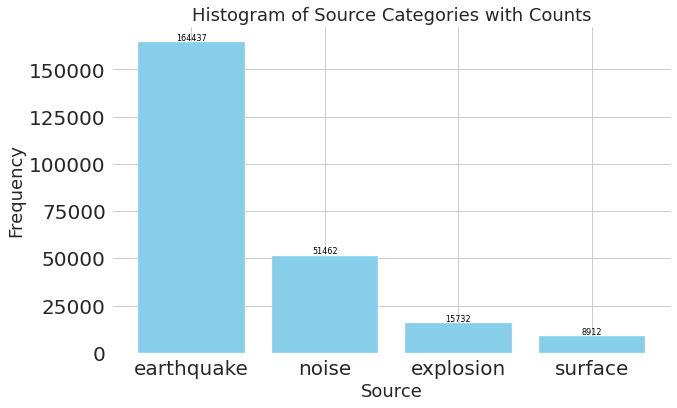

In [127]:
# Assuming 'source' is a categorical column in your DataFrame
categories, counts = features_all['source'].value_counts().index, features_all['source'].value_counts().values

plt.figure(figsize=(10, 6))

# Plot the histogram
plt.bar(categories, counts, color='skyblue')

# Add text annotations on top of each bar
for i, count in enumerate(counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=8, color='black')

plt.xlabel('Source')
plt.ylabel('Frequency')
plt.title('Histogram of Source Categories with Counts')

plt.show()


In [128]:
print(f'So we now have {outliers_removed_df.shape[0]} events and each event have {outliers_removed_df.shape[1]} features')

So we now have 171274 events and each event have 439 features


### Standardizing the features

In [129]:
## defining the global variables X and y
X = outliers_removed_df.drop(['serial_no','source'], axis = 1)
y = outliers_removed_df['source']


# Initialize the StandardScaler
scaler = StandardScaler()



# Apply standard scaling to the DataFrame
scaled_features = scaler.fit_transform(X)


# Access the mean and standard deviation for each feature
means = scaler.mean_
std_devs = scaler.scale_

# Create a DataFrame to display the means and standard deviations
scaler_params = pd.DataFrame({'Feature': X.columns, 'Mean': means, 'Std Dev': std_devs})
print(scaler_params)


# Create a new DataFrame with scaled features
X_scaled = pd.DataFrame(scaled_features, columns=X.columns)


## We are not standardizing at this stage. We will rather wait when the outlier are removed, then we will
## standardize and save the standard scaler parameters. 
#X_scaled = X

X_scaled['serial_no'] = outliers_removed_df['serial_no'].values
X_scaled['source'] = outliers_removed_df['source'].values

/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1745: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)


                  Feature          Mean       Std Dev
0             RappMaxMean  2.269184e+01  1.643076e+01
1           RappMaxMedian  6.427125e+01  1.371207e+02
2                   AsDec  9.100054e-01  1.098368e+00
3                KurtoSig  5.486203e+01  6.153273e+01
4                KurtoEnv  5.557935e+01  5.498508e+01
..                    ...           ...           ...
432     0_Signal distance  1.500636e+04  8.524333e+00
433               0_Slope -5.662960e-11  9.282066e-09
434   0_Sum absolute diff  2.343939e+02  1.846921e+02
435        0_Total energy  9.784893e-01  1.257359e+00
436  0_Zero crossing rate  1.428845e+03  3.911037e+02

[437 rows x 3 columns]


# IMP - Saving the Standard Scaler Params

#### X_scaled is a standardized dataframe

In [130]:
scaler_params.to_csv('/home/ak287/Data_Mining_in_the_PNW/Results/scaler_params.csv')

## Merging the metadata information with the features dataframe

In [131]:
# extracting the stored data
comcat_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/comcat_waveforms.hdf5",'r')
exotic_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/exotic_waveforms.hdf5",'r')
noise_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/noise_waveforms.hdf5",'r')


# extracting the catalog
comcat_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")
exotic_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
noise_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")



# extracting the metadata corresponding to individual events
cat_exp = comcat_file_csv[comcat_file_csv['source_type'] == 'explosion']
cat_eq = comcat_file_csv[comcat_file_csv['source_type'] == 'earthquake']
cat_no = noise_file_csv
cat_su = exotic_file_csv[exotic_file_csv['source_type'] == 'surface event']



# extracting the index 
ind_exp = X_scaled[X_scaled['source'] == 'explosion']['serial_no'].values
ind_eq = X_scaled[X_scaled['source'] == 'earthquake']['serial_no'].values
ind_no = X_scaled[X_scaled['source'] == 'noise']['serial_no'].values
ind_su = X_scaled[X_scaled['source'] == 'surface']['serial_no'].values


df_exp = X_scaled[X_scaled['source'] == 'explosion']
exp_df = cat_exp.iloc[ind_exp]
exp_df['serial_no'] = ind_exp


df_eq = X_scaled[X_scaled['source'] == 'earthquake']
eq_df = cat_eq.iloc[ind_eq]
eq_df['serial_no'] = ind_eq



df_no = X_scaled[X_scaled['source'] == 'noise']
no_df = cat_no.iloc[ind_no]
no_df['serial_no'] = ind_no



df_su = X_scaled[X_scaled['source'] == 'surface']
su_df = cat_su.iloc[ind_su]
su_df['serial_no'] = ind_su





new_exp = pd.merge(df_exp,exp_df, on = 'serial_no')
new_eq = pd.merge(df_eq,eq_df, on = 'serial_no')
new_su = pd.merge(df_su,su_df, on = 'serial_no')
new_no = pd.merge(df_no,no_df, on = 'serial_no')
new_no['event_id'] = np.array(['noise'+str(i) for i in np.arange(len(new_no))])



X_final = pd.concat([new_exp, new_eq, new_su, new_no])
y = ['explosion']*len(new_exp)+['earthquake']*len(new_eq)+['surface']*len(new_su)+['noise']*len(new_no)



/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


### Adding Hour of the Day, Days of Week and Month of Year as additional features as they have shown to significantly increase the performance of the machine learning model

In [132]:
# new_exp contains the features and the corresponding metadata information. 
datetimes = X_final['trace_start_time'].values

hour_of_day = []
days_of_week = []
month_of_year = []
for dt_str in tqdm(datetimes):
        
    # Parse the datetime string
        dt = datetime.strptime(dt_str, '%Y-%m-%dT%H:%M:%S.%fZ')
        hod = dt.hour - 8.  # converting to local time. 
        moy = dt.month
        
        
        days_of_week.append(dt.weekday())
        hour_of_day.append(hod)
        month_of_year.append(moy)
        
X_final['hour_of_day'] = hour_of_day
X_final['day_of_week'] = days_of_week
X_final['month_of_year'] = month_of_year


100%|██████████| 171274/171274 [00:01<00:00, 139051.04it/s]


In [133]:
temp_X = X_final.iloc[:,0:437]
#temp_X = temp_X.assign(hod=X_final['hour_of_day'].values, dow=X_final['day_of_week'].values, moy=X_final['month_of_year'].values)



# Initialize the StandardScaler
scaler = StandardScaler()

# Apply standard scaling to the DataFrame
scaled_features = scaler.fit_transform(temp_X)

# Create a new DataFrame with scaled features
temp_X = pd.DataFrame(scaled_features, columns= temp_X.columns)



## So X_final that contains the features and corresponding metadata information for all the events

### hyperparameter tuning of the model based on 3000 samples per class and splitting into 80-20%.

In [134]:
# Apply random undersampling using imbalanced-learn library
rus = RandomUnderSampler(sampling_strategy={'earthquake':3000, 'explosion':3000, 'surface':3000, 'noise':3000})
X_resampled, y_resampled = rus.fit_resample(temp_X, y)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the LabelEncoder on the text labels and transform them to numeric labels
y_num = label_encoder.fit_transform(y_resampled)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_num, test_size=0.2, stratify = y_num)



# Define the hyperparameter grid for randomized search
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Initialize the RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist, n_iter=50, scoring='f1_macro', cv=10, verbose=2, random_state=42, n_jobs=-1
)

# Perform randomized grid search cross-validation
random_search.fit(X_train, y_train)

# Print the best parameters and their corresponding accuracy score
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = np.sum(y_pred == y_test) / len(y_test)
print("Test Accuracy:", accuracy)




Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': False}
Best Accuracy: 0.933257549279
Test Accuracy: 0.935416666667


In [135]:
best_model

RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_split=5,
                       random_state=42)

## Saving the best model into disk so next time we can just load it

In [136]:
dump(best_model, '../Results/best_rf_model_all_features_10_40.joblib')

['../Results/best_rf_model_all_features_10_40.joblib']

## Loading the saved model from the disk

In [137]:
bf = load('../Results/best_rf_model_all_features_10_40.joblib')

In [138]:
bf

RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_split=5,
                       random_state=42)

### Performance with best model

Text(0.5, 1.0, 'Total samples: 2400')

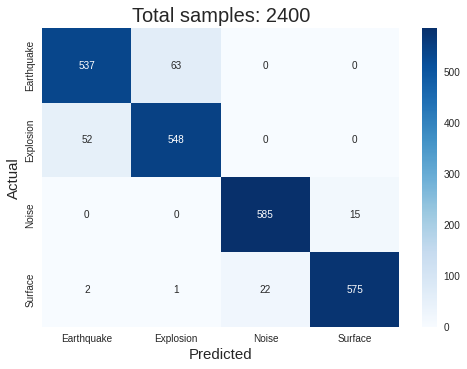

In [139]:
## Performance with best model

plt.style.use('seaborn')
cm = confusion_matrix(y_test, y_pred)


labels = ['Earthquake', 'Explosion','Noise','Surface']
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels = labels, yticklabels = labels)
plt.xlabel('Predicted', fontsize = 15)
plt.ylabel('Actual', fontsize = 15)
plt.title('Total samples: '+str(len(y_pred)), fontsize = 20)



### Classification report with best model

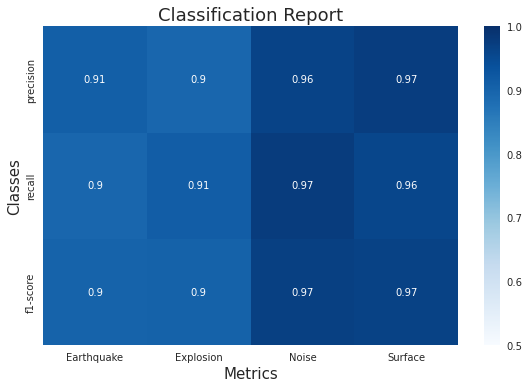

[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=  32.7s
[CV] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  39.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=  29.2s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  12.7s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  58.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 1.1min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=  28.7s
[CV] END bootstrap=False, max_depth=20, max_

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  22.4s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.7min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  21.1s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  24.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 1.1min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=  28.6s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  44.3s
[CV] END bootstrap=True, max_depth=10, m

[CV] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  43.0s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 1.8min
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  25.2s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  42.4s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  23.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=  28.7s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=  15.1s
[CV] END bootstrap=False, max_depth=10, m

[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=  33.4s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 1.8min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  12.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  11.9s
[CV] END bootstrap=True, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 1.8min
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  10.3s
[CV] END bootstrap=False, max_depth=10,

In [140]:
# Calculate the classification report
report = classification_report(y_test, y_pred, output_dict=True)
labels = ['Earthquake', 'Explosion', 'Noise','Surface']

# Set a pleasing style
sns.set_style("whitegrid")

# Create a figure and axes for the heatmap
plt.figure()
ax = sns.heatmap(pd.DataFrame(report).iloc[:3, :4], annot=True, cmap='Blues', xticklabels=labels, vmin=0.5, vmax=1)

# Set labels and title
ax.set_xlabel('Metrics', fontsize=15)
ax.set_ylabel('Classes', fontsize=15)
ax.set_title('Classification Report', fontsize=18)

# Create a colorbar
#cbar = ax.collections[0].colorbar
#cbar.set_ticks([0.5, 1])  # Set custom tick locations
#cbar.set_ticklabels(['0', '0.5', '1'])  # Set custom tick labels

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Feature Importance computation with built-in method over 10 iterations

In [27]:
num_iter = 10
f_imp = []

for i in tqdm(range(num_iter)):

    # Apply random undersampling using imbalanced-learn library
    rus = RandomUnderSampler(sampling_strategy={'earthquake':3000, 'explosion':3000, 'surface':3000, 'noise':3000})
    X_resampled, y_resampled = rus.fit_resample(temp_X, y)

    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()

    # Fit the LabelEncoder on the text labels and transform them to numeric labels
    y_num = label_encoder.fit_transform(y_resampled)


    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_num, test_size=0.2, stratify = y_num)

    # Perform randomized grid search cross-validation
    best_model.fit(X_train, y_train)


    f_imp.append(best_model.feature_importances_)

 30%|███       | 3/10 [02:17<05:21, 45.91s/it]

[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=  31.9s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 1.8min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  35.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 1.1min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=  28.8s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=  15.3s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  47.0s
[CV] END bootstrap=False, max_depth=

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  22.2s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.8min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  21.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  11.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  11.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 1.1min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=  28.5s
[CV] END bootstrap=False, max_depth=20, m

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  22.1s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   8.8s
[CV] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  39.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=  29.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  12.5s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  26.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  12.7s
[CV] END bootstrap=True, max_depth=3

 40%|████      | 4/10 [03:03<04:33, 45.63s/it]

[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  23.7s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  42.9s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  24.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=  29.1s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  21.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  35.5s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  22.0s
[CV] END bootstrap=False, max_depth=1

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  22.3s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.8min
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  40.2s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 1.8min
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  10.0s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=  25.4s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.1s
[CV] END bootstrap=True, max_depth=No

 50%|█████     | 5/10 [03:47<03:45, 45.17s/it]

[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=  31.8s
[CV] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  39.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=  29.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  12.6s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  58.9s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  17.1s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  22.2s
[CV] END bootstrap=True, max_depth=None, m

[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=  31.8s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 1.8min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  35.5s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  42.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 1.1min
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  23.5s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  21.3s
[CV] END bootstrap=False, max_depth

[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  21.3s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   8.7s
[CV] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  39.5s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  24.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  26.2s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  21.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  35.5s
[CV] END bootstrap=False, max_dep

100%|██████████| 10/10 [07:32<00:00, 45.24s/it]


In [28]:
final_imp = np.mean(f_imp, axis = 0)
features = X_train.columns.values
feature_colors = ['darkred']*60+['darkblue']*(len(features)-60)  # red for physical and blue for tsfel features. 


## Plotting the feature importance

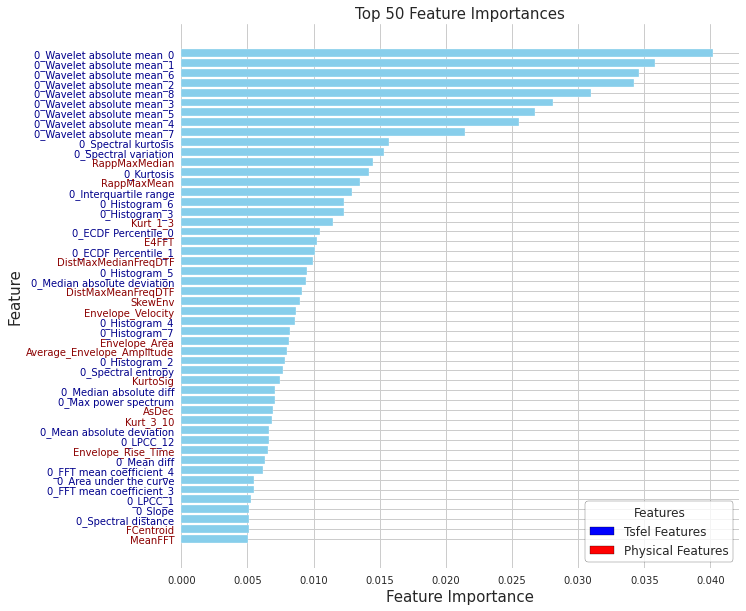

In [29]:
# Sample feature importances and feature labels
feature_importances = final_imp
feature_labels = features

# Sort feature importances and feature labels together
sorted_indices = sorted(range(len(feature_importances)), key=lambda k: feature_importances[k], reverse=True)
sorted_feature_importances = [feature_importances[i] for i in sorted_indices]
sorted_feature_labels = [feature_labels[i] for i in sorted_indices]
colors = [feature_colors[i] for i in sorted_indices]



# Plotting
plt.figure(figsize=(10, 10))
plt.barh(sorted_feature_labels[0:50], sorted_feature_importances[0:50], color='skyblue')


# Color yticklabels
for label, color in zip(plt.gca().get_yticklabels(), colors):
    label.set_color(color)
    
# Create legend handles and labels
legend_handles = [plt.Rectangle((0,0),1,1, color='blue', ec='black'), plt.Rectangle((0,0),1,1, color='red', ec='black')]
legend_labels = ['Tsfel Features', 'Physical Features']

plt.legend(legend_handles, legend_labels, title='Features', fontsize='large', title_fontsize='large', frameon=True, facecolor='white', edgecolor='black')


plt.xlabel('Feature Importance', fontsize = 15)
plt.ylabel('Feature', fontsize = 15)
plt.title('Top 50 Feature Importances', fontsize = 15)
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()


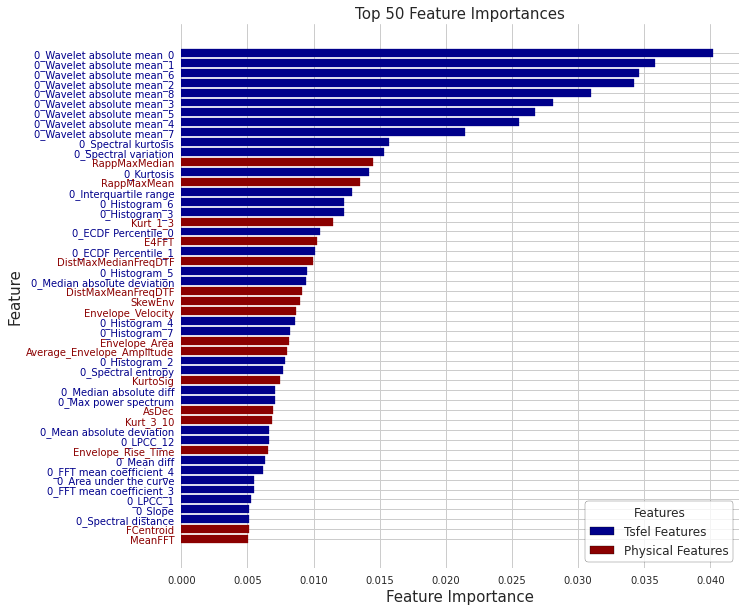

In [76]:
# Sample feature importances and feature labels
feature_importances = final_imp
feature_labels = features

# Sort feature importances and feature labels together
sorted_indices = sorted(range(len(feature_importances)), key=lambda k: feature_importances[k], reverse=True)
sorted_feature_importances = [feature_importances[i] for i in sorted_indices]
sorted_feature_labels = [feature_labels[i] for i in sorted_indices]
colors = [feature_colors[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(10, 10))
bars = plt.barh(sorted_feature_labels[0:50], sorted_feature_importances[0:50])

# Color bars to match yticklabels
for bar, color in zip(bars, colors):
    bar.set_color(color)

# Color yticklabels
for label, color in zip(plt.gca().get_yticklabels(), colors):
    label.set_color(color)

# Create legend handles and labels
legend_handles = [plt.Rectangle((0,0),1,1, color='darkblue', ec='black'), plt.Rectangle((0,0),1,1, color='darkred', ec='black')]
legend_labels = ['Tsfel Features', 'Physical Features']

plt.legend(legend_handles, legend_labels, title='Features', fontsize='large', title_fontsize='large', frameon=True, facecolor='white', edgecolor='black')

plt.xlabel('Feature Importance', fontsize=15)
plt.ylabel('Feature', fontsize=15)
plt.title('Top 50 Feature Importances', fontsize=15)
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()


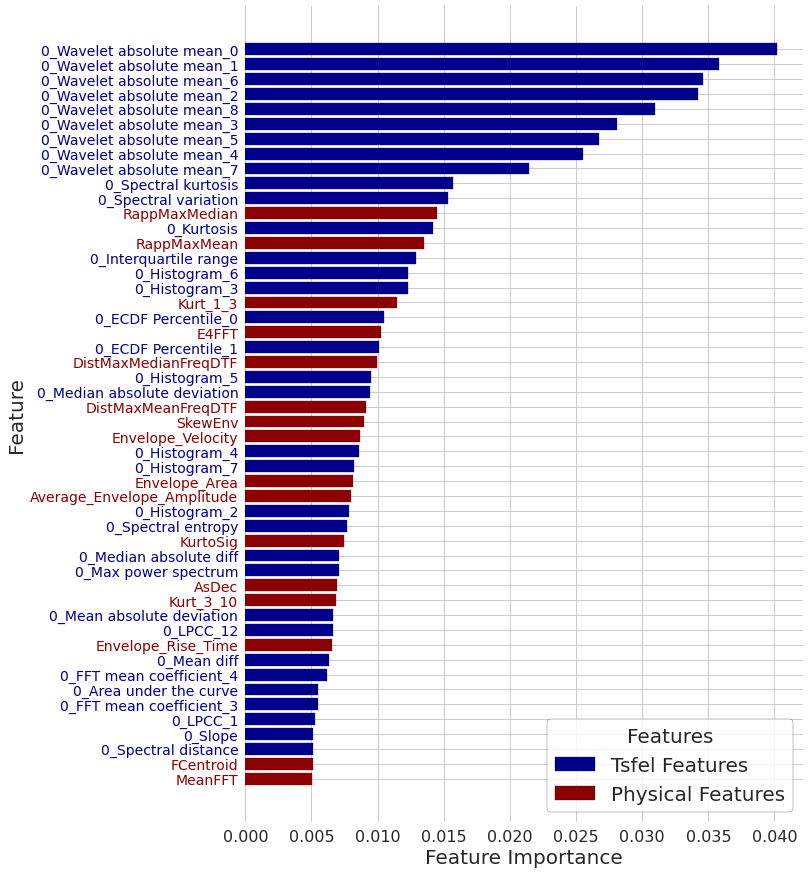

In [87]:
# Set rc parameters for font size
plt.rcParams['xtick.labelsize'] = 16  # Font size for xtick labels
plt.rcParams['ytick.labelsize'] = 20  # Font size for ytick labels
# Sample feature importances and feature labels
feature_importances = final_imp
feature_labels = features

# Sort feature importances and feature labels together
sorted_indices = sorted(range(len(feature_importances)), key=lambda k: feature_importances[k], reverse=True)
sorted_feature_importances = [feature_importances[i] for i in sorted_indices]
sorted_feature_labels = [feature_labels[i] for i in sorted_indices]
colors = [feature_colors[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(10, 15))
bars = plt.barh(sorted_feature_labels[0:50], sorted_feature_importances[0:50])

# Color bars to match yticklabels
for bar, color in zip(bars, colors):
    bar.set_color(color)

# Color yticklabels and increase font size
for label, color in zip(plt.gca().get_yticklabels(), colors):
    label.set_color(color)
    #label.set_fontsize(20)  # Set desired font size here

# Create legend handles and labels
legend_handles = [plt.Rectangle((0,0),1,1, color='darkblue', ec='black'), plt.Rectangle((0,0),1,1, color='darkred', ec='black')]
legend_labels = ['Tsfel Features', 'Physical Features']

plt.legend(legend_handles, legend_labels, title='Features', title_fontsize=20, frameon=True, fontsize = 20, facecolor='white', edgecolor='black')

plt.xlabel('Feature Importance', fontsize=20)
plt.ylabel('Feature', fontsize=20)
#plt.title('Top 50 Feature Importances', fontsize=20)
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top

# Set y-axis tick label size
plt.yticks(fontsize=14)

plt.show()


## Performance variation with the cumulative number of the most important features

In [31]:
## based on the X_train and X_test computed previously. They should contain 2400 and 600 events per class respectively. 
results_dict = []
selected_features = []

for i in tqdm(range(1, 100)):
    selected_features.append(sorted_feature_labels[i - 1])
    X_temp_train = X_train[selected_features].copy()
    X_temp_test = X_test[selected_features].copy()
    bf.fit(X_temp_train, y_train)
    
    y_pred = bf.predict(X_temp_test)
    results_dict.append(classification_report(y_test, y_pred, output_dict=True))


100%|██████████| 99/99 [22:15<00:00, 13.49s/it]


In [32]:
acc_features= [results_dict[i]['accuracy'] for i in range(len(results_dict))]

f1_features = [results_dict[i]['macro avg']['f1-score'] for i in range(len(results_dict))]
prec_features = [results_dict[i]['macro avg']['precision'] for i in range(len(results_dict))]
rec_features = [results_dict[i]['macro avg']['recall'] for i in range(len(results_dict))]

f1_su = [results_dict[i]['3']['f1-score'] for i in range(len(results_dict))]
prec_su = [results_dict[i]['3']['precision'] for i in range(len(results_dict))]
rec_su = [results_dict[i]['3']['recall'] for i in range(len(results_dict))]

f1_exp = [results_dict[i]['1']['f1-score'] for i in range(len(results_dict))]
prec_exp = [results_dict[i]['1']['precision'] for i in range(len(results_dict))]
rec_exp = [results_dict[i]['1']['recall'] for i in range(len(results_dict))]


f1_eq = [results_dict[i]['0']['f1-score'] for i in range(len(results_dict))]
prec_eq = [results_dict[i]['0']['precision'] for i in range(len(results_dict))]
rec_eq = [results_dict[i]['0']['recall'] for i in range(len(results_dict))]

In [40]:
import pickle



# Save the list using pickle.dump()
with open('f1_features.pkl', 'wb') as f:
    pickle.dump(f1_features, f)


/tmp/ipykernel_1485926/2945477197.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


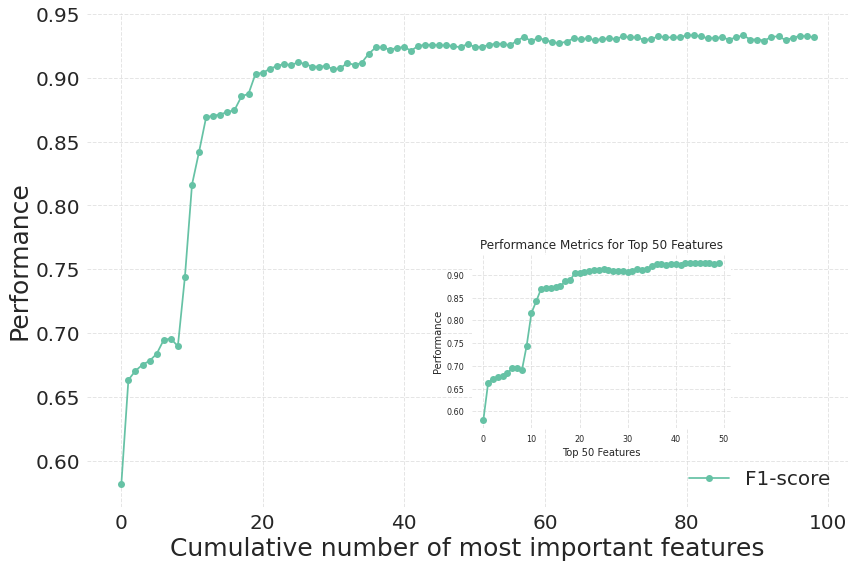

In [38]:
#import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Create a color palette
colors = cm.get_cmap('Set2', 4)

# Create a figure and axis for the main plot
fig, ax = plt.subplots(figsize=[12, 8])

# Main plot
ax.plot(np.arange(len(f1_features)), f1_features, marker='o', label='F1-score', color=colors(0), linestyle='-')
#ax.plot(np.arange(len(f1_features)), acc_features, marker='s', label='Accuracy', color=colors(1), linestyle='--')
#ax.plot(np.arange(len(f1_features)), prec_features, marker='^', label='Precision', color=colors(2), linestyle='-.')
#ax.plot(np.arange(len(f1_features)), rec_features, marker='d', label='Recall', color=colors(3), linestyle=':')
ax.legend(fontsize= 20, loc='lower right')
ax.set_xlabel('Cumulative number of most important features', fontsize=25)
ax.set_ylabel('Performance', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.grid(True, linestyle='--', alpha=0.5)
#ax.set_title('Performance Metrics vs. Number of Features', fontsize=25)

# Inset plot for top 50 features
left, bottom, width, height = [0.55, 0.25, 0.3, 0.3]  # Adjust position and size of inset
ax_inset = fig.add_axes([left, bottom, width, height])
ax_inset.plot(np.arange(50), f1_features[:50], marker='o', label='F1-score', color=colors(0), linestyle='-')
#ax_inset.plot(np.arange(50), acc_features[:50], marker='s', label='Accuracy', color=colors(1), linestyle='--')
#ax_inset.plot(np.arange(50), prec_features[:50], marker='^', label='Precision', color=colors(2), linestyle='-.')
#ax_inset.plot(np.arange(50), rec_features[:50], marker='d', label='Recall', color=colors(3), linestyle=':')
ax_inset.set_xlabel('Top 50 Features', fontsize=10)
ax_inset.set_ylabel('Performance', fontsize=10)
ax_inset.tick_params(axis='both', which='major', labelsize=8)
ax_inset.grid(True, linestyle='--', alpha=0.5)
ax_inset.set_title('Performance Metrics for Top 50 Features', fontsize=12)

plt.tight_layout()
plt.show()


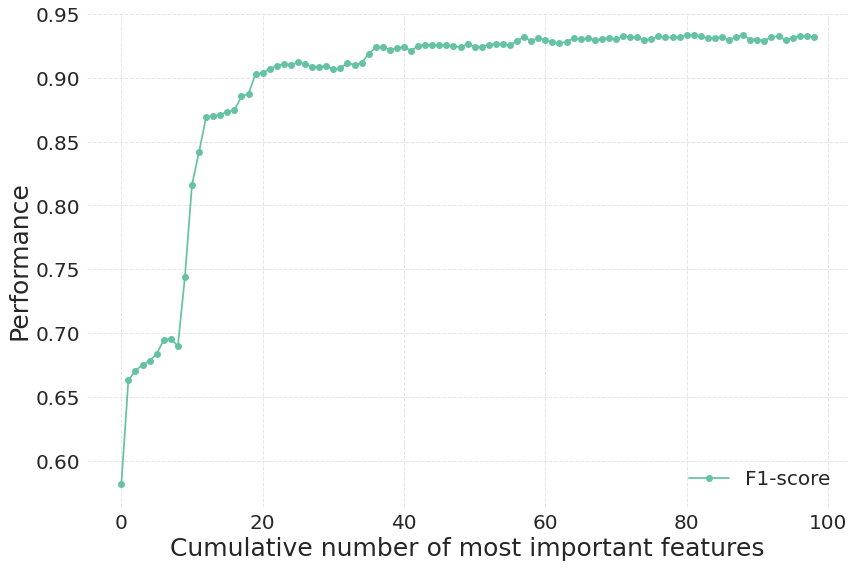

In [41]:
#import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Create a color palette
colors = cm.get_cmap('Set2', 4)

# Create a figure and axis for the main plot
fig, ax = plt.subplots(figsize=[12, 8])

# Main plot
ax.plot(np.arange(len(f1_features)), f1_features, marker='o', label='F1-score', color=colors(0), linestyle='-')
#ax.plot(np.arange(len(f1_features)), acc_features, marker='s', label='Accuracy', color=colors(1), linestyle='--')
#ax.plot(np.arange(len(f1_features)), prec_features, marker='^', label='Precision', color=colors(2), linestyle='-.')
#ax.plot(np.arange(len(f1_features)), rec_features, marker='d', label='Recall', color=colors(3), linestyle=':')
ax.legend(fontsize= 20, loc='lower right')
ax.set_xlabel('Cumulative number of most important features', fontsize=25)
ax.set_ylabel('Performance', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.grid(True, linestyle='--', alpha=0.5)
#ax.set_title('Performance Metrics vs. Number of Features', fontsize=25)



plt.tight_layout()
plt.show()


## In the following code, we are randomly selecting 5000 "Events" per class,  and separating them from the testing dataset

## First let's remove the events that have different labels assigned by USGS and PNSN, apparently there are 15 such events corresponding to 293 traces

In [141]:
## extracting metadata information for each kind of source along with features
a_eq = X_final[X_final['source_type_pnsn_label'] == 'eq']
## removing the ambiguous events
a_eq = a_eq[a_eq['source_type'] != 'explosion']

a_px = X_final[X_final['source_type_pnsn_label'] == 'px']
# removing the ambiguous events. 
a_px = a_px[a_px['source_type'] != 'earthquake']

a_su = X_final[X_final['source_type'] == 'surface event']
a_no = X_final[X_final['source_type'] == 'noise']



## extracting the event ids corresponding to each catalog
eq_ids = np.unique(a_eq['event_id'].values)
su_ids = np.unique(a_su['event_id'].values)
no_ids = np.unique(a_no['event_id'].values)
px_ids = np.unique(a_px['event_id'].values)


## defining the events for training and testing in 70:30 ratio


"""

Modifying this section a bit, for a fair comparison to deep neural network. 


train_eq = eq_ids[0:int(0.7*len(eq_ids))]
train_px = px_ids[0:int(0.7*len(px_ids))]
train_su = su_ids[0:int(0.7*len(su_ids))]
train_no = no_ids[0:int(0.7*len(no_ids))]


test_eq = eq_ids[int(0.7*len(eq_ids)):len(eq_ids)]
test_px = px_ids[int(0.7*len(px_ids)):len(px_ids)]
test_su = su_ids[int(0.7*len(su_ids)):len(su_ids)]
test_no = no_ids[int(0.7*len(no_ids)):len(no_ids)]


"""

## randomizing along the time. 
r1 = np.random.randint(0, len(eq_ids), 5000)
train_eq = eq_ids[r1]

## randomizing along the time. 
r2 = np.random.randint(0, len(px_ids), 5000)
train_px = px_ids[r2]

## randomizing along the time. 
r3 = np.random.randint(0, len(su_ids), 5000)
train_su = su_ids[r3]

## randomizing along the time
r4 = np.random.randint(0, len(no_ids), 5000)
train_no = no_ids[r4]



mask_eq = np.ones(eq_ids.shape, dtype = bool)
mask_eq[r1] = False

mask_px = np.ones(px_ids.shape, dtype = bool)
mask_px[r2] = False

mask_su = np.ones(su_ids.shape, dtype = bool)
mask_su[r3] = False

mask_no = np.ones(no_ids.shape, dtype = bool)
mask_no[r4] = False

test_eq = eq_ids[mask_eq]
test_px = px_ids[mask_px]
test_su = su_ids[mask_su]
test_no = no_ids[mask_no]



# concatenating training ids
all_train_ids = np.concatenate([train_eq,train_px, train_su, train_no])

# concatenating testing ids
all_test_ids = np.concatenate([test_eq,test_px, test_su, test_no])

# allocating event id as index
X_final.index = X_final['event_id'].values


# extracting training and testing values
X_train = X_final.loc[all_train_ids]
X_test = X_final.loc[all_test_ids]



Y_train = X_train['source_type'].values
Y_test = X_test['source_type'].values

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  22.7s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.8min
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  40.6s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  16.7s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  21.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 1.1min
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=  15.2s
[CV] END bootstrap=False, max_depth

## We can experiment by removing and adding the manual features in the cell below to see how much they contribute to performance

In [142]:
# Case 1: without adding anything manual
## Check the performance 
x_train = X_train.iloc[:, 0:437]
#x_train = x_train.assign(hod=X_train['hour_of_day'].values, dow=X_train['day_of_week'].values, moy=X_train['month_of_year'].values)

x_test = X_test.iloc[:, 0:437]
#x_test = x_test.assign(hod=X_test['hour_of_day'].values, dow=X_test['day_of_week'].values, moy=X_test['month_of_year'].values)



## Training the model on 5000 randomly samples waveforms per class and testing it on the remaining dataset

In [143]:
# initiating a random undersampler
rus = RandomUnderSampler(sampling_strategy={'earthquake':5000, 'explosion':5000,'surface event':5000,'noise':5000}, random_state = 42)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Converting the textual labels into numerical labels
y_num_test = label_encoder.fit_transform(Y_test)


# randomly taking 5000 samples per class from the training dataset
X_resampled, y_resampled = rus.fit_resample(x_train, Y_train)


# Fit the LabelEncoder on the text labels and transform them to numeric labels
y_num_res = label_encoder.fit_transform(y_resampled)



best_model.class_weight  = None
best_model.fit(X_resampled, y_num_res)




[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  21.6s
[CV] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  42.7s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  44.1s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  25.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  12.5s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  26.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 1.1min
[CV] END bootstrap=True, max_depth=1

[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  23.9s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  41.4s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  44.3s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  26.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  12.5s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  24.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 1.1min
[CV] END bootstrap=True, max_depth=20,

[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  22.0s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   8.6s
[CV] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  39.8s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=  28.9s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  12.9s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  26.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  12.8s
[CV] END bootstrap=True, max_depth=30

RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_split=5,
                       random_state=42)

## Trace wise performance

[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  24.7s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  43.0s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  24.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  26.6s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  59.9s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  22.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.3min
[CV] END bootstrap=True, max_depth=30, m

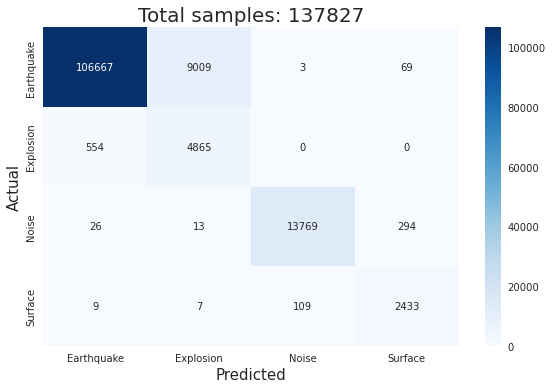

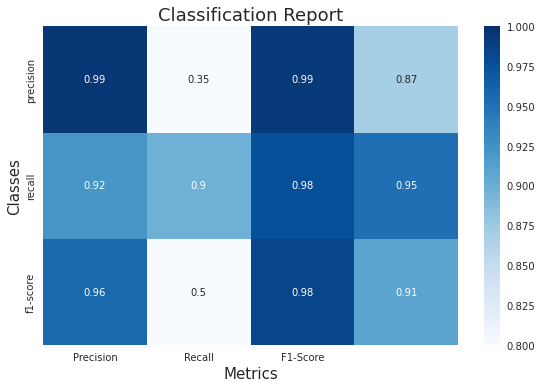

In [144]:
y_pred = best_model.predict(x_test)
plt.style.use('seaborn')
trace_cm_phy_tsf = confusion_matrix(y_num_test, y_pred)


labels = ['Earthquake', 'Explosion','Noise','Surface']
plt.figure()
sns.heatmap(trace_cm_phy_tsf, annot=True, cmap='Blues', fmt='d', xticklabels = labels, yticklabels = labels)
plt.xlabel('Predicted', fontsize = 15)
plt.ylabel('Actual', fontsize = 15)
plt.title('Total samples: '+str(len(y_pred)), fontsize = 20)
# Adjust layout
plt.tight_layout()



# Calculate the classification report
trace_report_phy_tsf = classification_report(y_num_test, y_pred, output_dict=True)
labels = ['Precision', 'Recall', 'F1-Score']

# Set a pleasing style
sns.set_style("whitegrid")

# Create a figure and axes for the heatmap
plt.figure()
ax = sns.heatmap(pd.DataFrame(trace_report_phy_tsf).iloc[:3, :4], annot=True, cmap='Blues', xticklabels=labels, vmin=0.8, vmax=1)

# Set labels and title
ax.set_xlabel('Metrics', fontsize=15)
ax.set_ylabel('Classes', fontsize=15)
ax.set_title('Classification Report', fontsize=18)

# Create a colorbar
#cbar = ax.collections[0].colorbar
#cbar.set_ticks([0.5, 1])  # Set custom tick locations
#cbar.set_ticklabels(['0', '0.5', '1'])  # Set custom tick labels

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Event wise performance

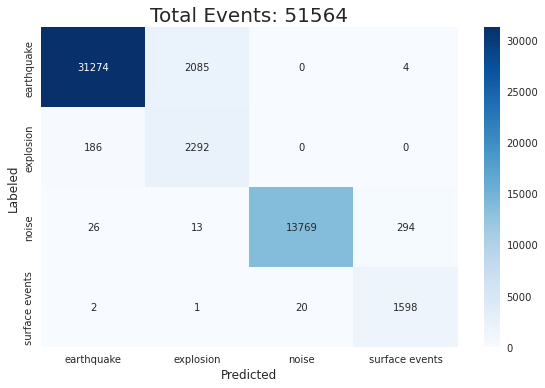

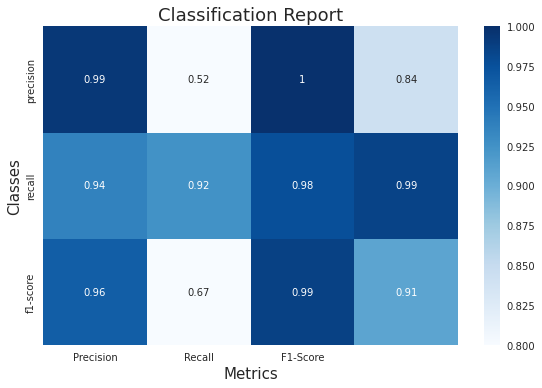

In [145]:
probs_all = best_model.predict_proba(x_test)

X_test['labelled'] = y_num_test
X_test['classified'] = y_pred
X_test['eq_probability'] = probs_all[:,0]
X_test['px_probability'] = probs_all[:,1]
X_test['no_probability'] = probs_all[:,2]
X_test['su_probability'] = probs_all[:,3]


mean_labels = X_test.groupby('event_id').mean()['labelled'].values
mean_ids = X_test.groupby('event_id').mean().index.values



mean_eq_prob = X_test.groupby('event_id').mean()['eq_probability'].values
mean_px_prob = X_test.groupby('event_id').mean()['px_probability'].values
mean_no_prob = X_test.groupby('event_id').mean()['no_probability'].values
mean_su_prob = X_test.groupby('event_id').mean()['su_probability'].values



temp_class = np.argmax(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)
temp_probs = np.max(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)



cf_events_phy_tsf = confusion_matrix(mean_labels, temp_class)
#cf_norm = cf_events/np.sum(cf_events, axis = 1, keepdims = True)
labels = ['earthquake','explosion','noise','surface events']

plt.figure()
ax = sns.heatmap(cf_events_phy_tsf, annot = True, cmap='Blues', xticklabels = labels, yticklabels = labels,  fmt="1.0f")
ax.set_xlabel('Predicted', fontsize = 12)
ax.set_ylabel('Labeled', fontsize = 12)
ax.set_title('Total Events: '+str(len(mean_labels)), fontsize = 20)
plt.tight_layout()




# Calculate the classification report
report_event_phy_tsf = classification_report(mean_labels, temp_class, output_dict=True)
labels = ['Precision', 'Recall', 'F1-Score']

# Set a pleasing style
sns.set_style("whitegrid")

# Create a figure and axes for the heatmap
plt.figure()
ax = sns.heatmap(pd.DataFrame(report_event_phy_tsf).iloc[:3, :4], annot=True, cmap='Blues', xticklabels=labels, vmin=0.8, vmax=1)

# Set labels and title
ax.set_xlabel('Metrics', fontsize=15)
ax.set_ylabel('Classes', fontsize=15)
ax.set_title('Classification Report', fontsize=18)

# Create a colorbar
#cbar = ax.collections[0].colorbar
#cbar.set_ticks([0.5, 1])  # Set custom tick locations
#cbar.set_ticklabels(['0', '0.5', '1'])  # Set custom tick labels

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


### Performance after adding Manual Features (HOD, DOW, MOY)

In [146]:
# Case 1: without adding anything manual
## Check the performance 
x_train = X_train.iloc[:, 0:437]
x_train = x_train.assign(hod=X_train['hour_of_day'].values, dow=X_train['day_of_week'].values, moy=X_train['month_of_year'].values)

x_test = X_test.iloc[:, 0:437]
x_test = x_test.assign(hod=X_test['hour_of_day'].values, dow=X_test['day_of_week'].values, moy=X_test['month_of_year'].values)



In [147]:
# initiating a random undersampler
rus = RandomUnderSampler(sampling_strategy={'earthquake':5000, 'explosion':5000,'surface event':5000,'noise':5000}, random_state = 42)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Converting the textual labels into numerical labels
y_num_test = label_encoder.fit_transform(Y_test)


# randomly taking 5000 samples per class from the training dataset
X_resampled, y_resampled = rus.fit_resample(x_train, Y_train)


# Fit the LabelEncoder on the text labels and transform them to numeric labels
y_num_res = label_encoder.fit_transform(y_resampled)



best_model.class_weight  = None
best_model.fit(X_resampled, y_num_res)




RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_split=5,
                       random_state=42)

## Trace wise performance

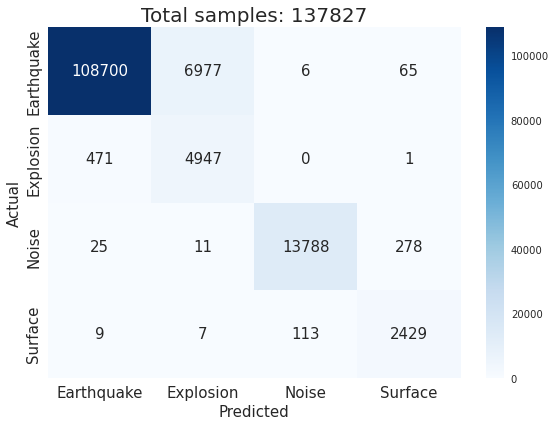

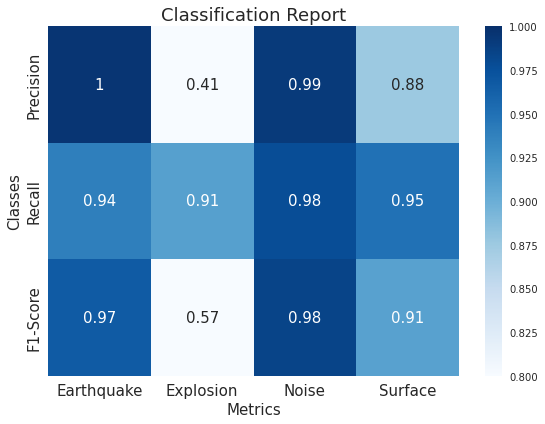

In [148]:
y_pred = best_model.predict(x_test)
plt.style.use('seaborn')
trace_cm_phy_tsf_man = confusion_matrix(y_num_test, y_pred)


class_labels = ['Earthquake', 'Explosion','Noise','Surface']
plt.figure(figsize = [8,6])

# Set annotation font size within each block
annot_kws = {"fontsize": 15}
ax = sns.heatmap(trace_cm_phy_tsf_man, annot=True, cmap='Blues', fmt='d', xticklabels = class_labels, yticklabels = class_labels, annot_kws=annot_kws)


# Set tick label font size
ax.set_xticklabels(class_labels, fontsize=15)
ax.set_yticklabels(class_labels, fontsize=15)


plt.xlabel('Predicted', fontsize = 15)
plt.ylabel('Actual', fontsize = 15)
plt.title('Total samples: '+str(len(y_pred)), fontsize = 20)
plt.tight_layout()


# Calculate the classification report
trace_report_phy_tsf_man = classification_report(y_num_test, y_pred, output_dict=True)
labels = ['Precision', 'Recall', 'F1-Score']

# Set a pleasing style
sns.set_style("whitegrid")

# Create a figure and axes for the heatmap
plt.figure(figsize = [8,6])
ax = sns.heatmap(pd.DataFrame(trace_report_phy_tsf_man).iloc[:3, :4], annot=True, cmap='Blues', yticklabels = labels, xticklabels=class_labels, vmin=0.8, vmax=1, annot_kws=annot_kws)

# Set labels and title
# Set tick label font size
ax.set_xticklabels(class_labels, fontsize=15)
ax.set_yticklabels(labels, fontsize=15)

ax.set_xlabel('Metrics', fontsize=15)
ax.set_ylabel('Classes', fontsize=15)
ax.set_title('Classification Report', fontsize=18)

# Create a colorbar
#cbar = ax.collections[0].colorbar
#cbar.set_ticks([0.5, 1])  # Set custom tick locations
#cbar.set_ticklabels(['0', '0.5', '1'])  # Set custom tick labels

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Event Wise Performance

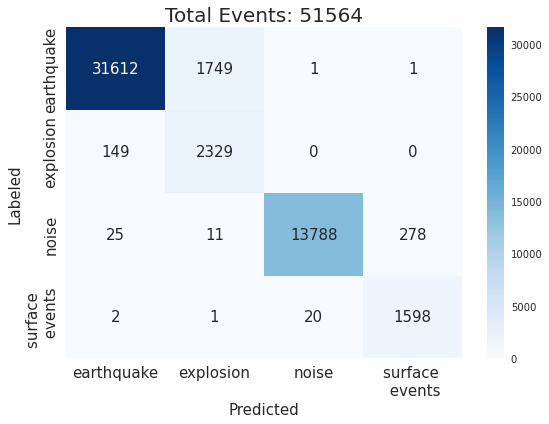

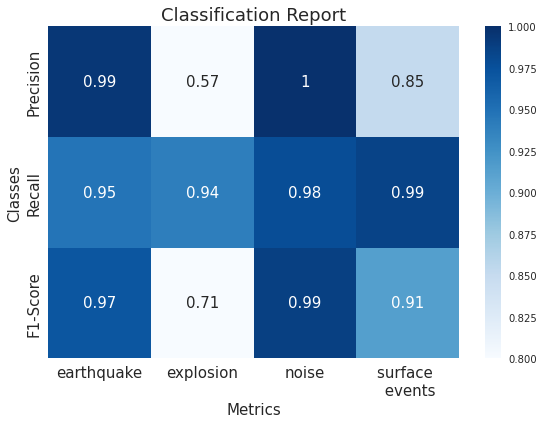

In [149]:
probs_all = best_model.predict_proba(x_test)

X_test['labelled'] = y_num_test
X_test['classified'] = y_pred
X_test['eq_probability'] = probs_all[:,0]
X_test['px_probability'] = probs_all[:,1]
X_test['no_probability'] = probs_all[:,2]
X_test['su_probability'] = probs_all[:,3]


mean_labels = X_test.groupby('event_id').mean()['labelled'].values
mean_ids = X_test.groupby('event_id').mean().index.values



mean_eq_prob = X_test.groupby('event_id').mean()['eq_probability'].values
mean_px_prob = X_test.groupby('event_id').mean()['px_probability'].values
mean_no_prob = X_test.groupby('event_id').mean()['no_probability'].values
mean_su_prob = X_test.groupby('event_id').mean()['su_probability'].values



## Assigning an event class based on the maximum average probability across the stations. 
temp_class = np.argmax(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)
## Computing the maximum averaged probability. 
temp_probs = np.max(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)



cf_events_phy_tsf_man = confusion_matrix(mean_labels, temp_class)
#cf_norm = cf_events/np.sum(cf_events, axis = 1, keepdims = True)
class_labels = ['earthquake','explosion','noise','surface \n events']

plt.figure(figsize = [8, 6])
ax = sns.heatmap(cf_events_phy_tsf_man, annot = True, cmap='Blues', xticklabels = class_labels, yticklabels = class_labels,  fmt="1.0f", annot_kws=annot_kws)
# Set tick label font size
ax.set_xticklabels(class_labels, fontsize=15)
ax.set_yticklabels(class_labels, fontsize=15)

ax.set_xlabel('Predicted', fontsize = 15)
ax.set_ylabel('Labeled', fontsize = 15)
ax.set_title('Total Events: '+str(len(mean_labels)), fontsize = 20)
plt.tight_layout()




# Calculate the classification report
report_event_phy_tsf_man = classification_report(mean_labels, temp_class, output_dict=True)
labels = ['Precision', 'Recall', 'F1-Score']

# Set a pleasing style
sns.set_style("whitegrid")

# Create a figure and axes for the heatmap
plt.figure(figsize = [8,6])
ax = sns.heatmap(pd.DataFrame(report_event_phy_tsf_man).iloc[:3, :4], annot=True, cmap='Blues', yticklabels=labels, xticklabels = class_labels,  vmin=0.8, vmax=1,  annot_kws=annot_kws)

# Set tick label font size
ax.set_xticklabels(class_labels, fontsize=15)
ax.set_yticklabels(labels, fontsize=15)

# Set labels and title
ax.set_xlabel('Metrics', fontsize=15)
ax.set_ylabel('Classes', fontsize=15)
ax.set_title('Classification Report', fontsize=18)

# Create a colorbar
#cbar = ax.collections[0].colorbar
#cbar.set_ticks([0.5, 1])  # Set custom tick locations
#cbar.set_ticklabels(['0', '0.5', '1'])  # Set custom tick labels

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Saving results of different models

In [150]:
# Saving every result into disk

# Saving trace results

## physical + tsfel
# Save to a file
with open('../Results/trace_report_phy_tsf.pkl', 'wb') as pickle_file:
    pickle.dump(trace_report_phy_tsf, pickle_file)

    
# Save to a file
with open('../Results/trace_confusion_matrix_phy_tsf.pkl', 'wb') as pickle_file:
    pickle.dump(trace_cm_phy_tsf, pickle_file)
    
    

# Saving event results

with open('../Results/event_report_phy_tsf.pkl', 'wb') as pickle_file:
    pickle.dump(report_event_phy_tsf, pickle_file)

    

with open('../Results/event_confusion_matrix_phy_tsf.pkl', 'wb') as pickle_file:
    pickle.dump(cf_events_phy_tsf, pickle_file)

    
    
## physical + tsfel + manual
    
    
# Save to a file
with open('../Results/trace_report_phy_tsf_man.pkl', 'wb') as pickle_file:
    pickle.dump(trace_report_phy_tsf_man, pickle_file)

    
# Save to a file
with open('../Results/trace_confusion_matrix_phy_tsf_man.pkl', 'wb') as pickle_file:
    pickle.dump(trace_cm_phy_tsf_man, pickle_file)
    
    

# Saving event results

with open('../Results/event_report_phy_tsf_man.pkl', 'wb') as pickle_file:
    pickle.dump(report_event_phy_tsf_man, pickle_file)

    

with open('../Results/event_confusion_matrix_phy_tsf_man.pkl', 'wb') as pickle_file:
    pickle.dump(cf_events_phy_tsf_man, pickle_file)

## Saving the dataset on which the model was trained 

In [151]:
## saving the final outlier removed dataset for ease of comparison among different features.
X_final.to_csv('../Results/common_dataset.csv')

In [152]:
## Saving the common testing dataset
X_test.to_csv('../Results/common_test_dataset.csv')

In [153]:
## Saving the common 
X_train.to_csv('../Results/common_train_dataset.csv')

## Analysing Misclassified Events

In [154]:
# probabilities corresponding to misclassified events
misclassified_probs = temp_probs[np.where(mean_labels != temp_class)]

# classification provided to misclassified events
misclassified_class = temp_class[np.where(mean_labels != temp_class)]

# labels provided to misclassified events. 
misclassified_labels = mean_labels[np.where(mean_labels != temp_class)]

# event ids provided to misclassified events. 
misclassified_ids = mean_ids[np.where(mean_labels != temp_class)]

# event ids from misclassified events where mean probabilities exceed 0.8
misclassified_high_prob = misclassified_ids[np.where(misclassified_probs > 0.8)]


# Dataframe of misclassified events
misclassified_X = X_test.loc[misclassified_high_prob]



In [273]:
len(misclassified_ids)

2237

In [270]:
len(np.unique(miss_eq['event_id']))

317

658

In [246]:
## Finding mislabelled events for each class
miss_exp = misclassified_X[misclassified_X['source_type'] == 'explosion']
miss_eq = misclassified_X[misclassified_X['source_type'] == 'earthquake']
miss_su = misclassified_X[misclassified_X['source_type'] == 'surface event']
miss_no = misclassified_X[misclassified_X['source_type'] == 'noise']

In [247]:
miss_exp.to_csv('../Results/missclassified_explosions_with_80.csv')
miss_eq.to_csv('../Results/missclassified_earthquake_with_80.csv')
miss_su.to_csv('../Results/missclassified_surface_with_80.csv')
miss_no.to_csv('../Results/missclassified_noise_with_80.csv')

In [262]:
l


RappMaxMean  RappMaxMedian     AsDec  KurtoSig  KurtoEnv  \
uw10551388     0.191744       0.612855  0.629368 -0.116638 -0.348661   
uw10557603    -0.428248      -0.288366 -0.167701 -0.427539 -0.509259   
uw10560933    -0.521593      -0.222861 -0.164258 -0.689591 -0.831717   
uw10560933    -0.600797      -0.273251  0.359348 -0.688584 -0.829860   
uw10564588     0.563357       0.094596 -0.267269  0.387207 -0.014329   
...                 ...            ...       ...       ...       ...   
uw61880886    -0.584049      -0.335486 -0.280160 -0.515001 -0.545293   
uw61881697    -0.739783      -0.358988 -0.083510 -0.612469 -0.675408   
uw61881697    -0.693557      -0.338940 -0.029420 -0.668947 -0.755716   
uw61881697    -0.672468      -0.356083  0.053140 -0.550182 -0.545866   
uw61886406    -0.025402       0.030373 -0.315292 -0.305176 -0.567099   

             SkewSig   SkewEnv  CorPeakNumber  Energy1/3Cor  Energy2/3Cor  \
uw10551388 -0.904873 -0.110984      -1.891645     -0.203681      0.258672   
uw10557603 -0.142031 -0.261305      -1.614596      0.268979      0.364601   
uw10560933 -0.104283 -0.874311      -0.730485     -0.165696      0.142809   
uw10560933  0.493782 -0.871464      -1.451626      0.168433     -0.102901   
uw10564588  2.221874  0.519925      -2.054614     -0.086547      0.242326   
...              ...       ...            ...           ...           ...   
uw61880886 -0.076712 -0.350890      -0.917900      0.288364     -0.189936   
uw61881697  0.139287 -0.546989      -1.011607      0.070262     -0.129168   
uw61881697 -0.544618 -0.741990      -1.533111      0.617233     -0.480130   
uw61881697  0.152058 -0.365921      -0.514549      0.168563      0.272683   
uw61886406  0.103658 -0.236279      -1.036053      0.127974     -0.026189   

            int_ratio  E_0.1_1     E_1_3    E_3_10   E_10_20   E_20_50  \
uw10551388  -0.013563     -0.0  0.100738 -0.791365 -1.773147 -0.002416   
uw10557603   0.058179     -0.0  0.617071 -0.237653 -0.326861 -0.002416   
uw10560933  -0.034169     -0.0  0.522837  0.557917  0.271944 -0.002416   
uw10560933  -0.039574     -0.0  0.650558  0.308759 -0.129552 -0.002416   
uw10564588   0.006578     -0.0 -0.279819 -1.507805 -2.142607 -0.002416   
...               ...      ...       ...       ...       ...       ...   
uw61880886  -0.038673     -0.0  0.430957  0.594685 -0.084326 -0.002416   
uw61881697   0.004016     -0.0  0.882738  0.512989  0.107969 -0.002416   
uw61881697  -0.031457     -0.0  0.898224  0.215614 -0.221840 -0.002416   
uw61881697   0.052652     -0.0  0.774102  0.450744 -0.224113 -0.002416   
uw61886406  -0.122781     -0.0 -0.106695 -0.207538 -0.688654 -0.002416   

            Kurt_0.1_1  Kurt_1_3  Kurt_3_10  Kurt_10_20  Kurt_20_50  \
uw10551388        -0.0  0.756604  -0.467557   -0.575320        -0.0   
uw10557603        -0.0 -0.048657   0.422883   -0.525729        -0.0   
uw10560933        -0.0 -0.535969  -0.705549   -0.735123        -0.0   
uw10560933        -0.0 -0.397222  -0.794809   -0.815825        -0.0   
uw10564588        -0.0  1.617525   0.742183   -0.160150        -0.0   
...                ...       ...        ...         ...         ...   
uw61880886        -0.0 -0.304443  -0.553619   -0.863383        -0.0   
uw61881697        -0.0 -0.072177  -0.820747   -0.936019        -0.0   
uw61881697        -0.0 -0.359551  -0.741052   -0.910732        -0.0   
uw61881697        -0.0  0.258294  -0.810242   -0.943581        -0.0   
uw61886406        -0.0  0.336889  -0.393624   -0.116325        -0.0   

            RMSDecPhaseLine   MeanFFT    MaxFFT   FMaxFFT  MedianFFT  \
uw10551388         0.413840 -0.628235 -0.190064 -0.701920  -0.694589   
uw10557603        -0.161330 -0.112472  0.205621 -1.109552  -0.254193   
uw10560933        -0.070851  0.370908 -0.152587 -0.474208  -0.447973   
uw10560933         0.124148 -0.087116  0.108470 -0.373003  -0.351024   
uw10564588        -0.242776 -0.763779 -0.198565 -1.191078  -0.757991   
...                     ...       ...       ... 

569

## Misclassified Explosions

In [173]:
## Finding mislabelled events for each class
miss_exp = misclassified_X[misclassified_X['source_type'] == 'explosion']
miss_eq = misclassified_X[misclassified_X['source_type'] == 'earthquake']
miss_su = misclassified_X[misclassified_X['source_type'] == 'surface event']
miss_no = misclassified_X[misclassified_X['source_type'] == 'noise']

## extracting data
p_arrivals= miss_exp['trace_P_arrival_sample'].values  ## We have P arrivals for the comcat events. 
buck_exp = [miss_exp['trace_name'].values[i].split('$')[0] for i in range(len(miss_exp))]
ind_exp = [int(miss_exp['trace_name'].values[i].split('$')[1].split(',')[0]) for i in range(len(miss_exp))]


## loading the data
data_exp = []
for i in range(len(buck_exp)):
    data_exp.append(comcat_file_name['/data/'+buck_exp[i]][ind_exp[i], 2, :15000])
    

## Processing the data
## This is to show the input before extracting features. 
data_exp = np.array(data_exp)

# Applying 10% cosine taper
tapered_exp = apply_cosine_taper(data_exp)

# Applying bandpass filter 1-10 Hz. (4 cornered)
final_exp = butterworth_filter(tapered_exp, 1, 10, 100, 4)

# Normalizing the data to remove the instrumental effect
norm_exp = final_exp/np.max(abs(np.array(final_exp)), axis = 1).reshape(-1,1)




## Assigning colors to each event id
# Example list of unique values
unique_values = miss_exp['event_id'].values# Your list here

# Choose a color palette
palette = sns.color_palette("dark", n_colors=len(unique_values))

# Create a mapping of unique values to colors
value_to_color = {value: color for value, color in zip(unique_values, palette)}

# Assign colors to the values
colors_list = [value_to_color[value] for value in unique_values]



labels = ['earthquake','explosion','noise','surface events']

#norm_exp = norm_exp[0:25]
#miss_exp = miss_exp[0:25]

## Assigned class and the probability
miss_exp_probs = np.max(miss_exp.iloc[:,481:485], axis = 1)
numerical_labels = np.argmax(miss_exp.iloc[:,481:485].values, axis = 1)
cat_labels = [labels[numerical_labels[i]] for i in range(len(numerical_labels))]
miss_ids = miss_exp['event_id'].values
miss_stns = (miss_exp['station_network_code']+'.'+miss_exp['station_code']+'.'+miss_exp['station_channel_code']+'Z').values

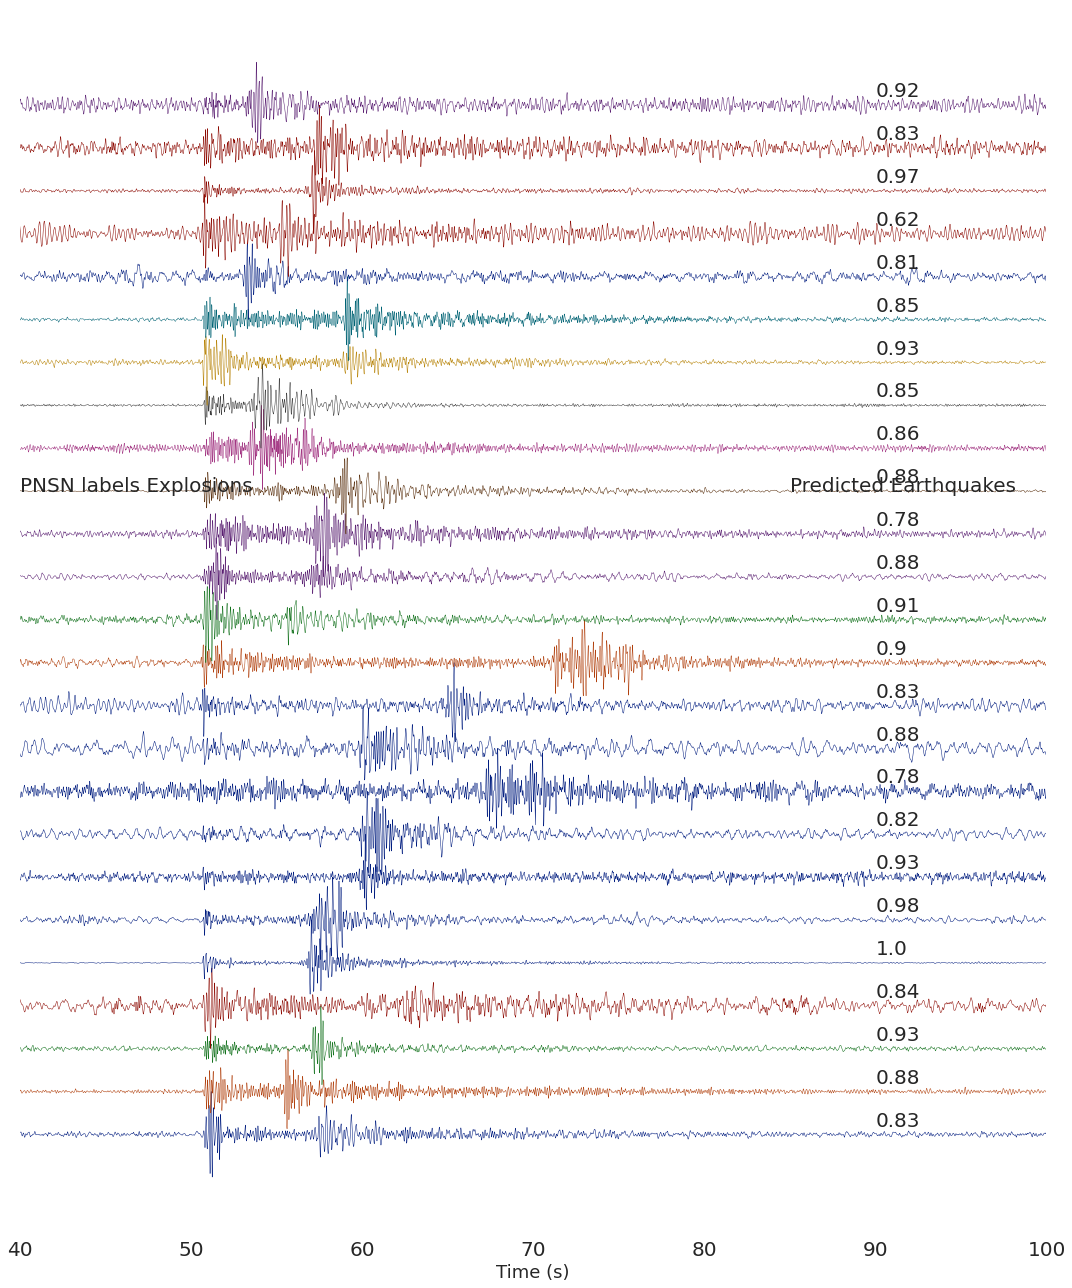

In [174]:

sns.set_style('whitegrid')

# Set rc parameters for font size
plt.rcParams['xtick.labelsize'] = 20  # Font size for xtick labels
plt.rcParams['ytick.labelsize'] = 20  # Font size for ytick labels
plt.rcParams['axes.labelsize'] = 18   # Font size for axis labels
plt.rcParams['axes.titlesize'] = 18   # Font size for title



# Create a figure and axes
fig, ax = plt.subplots(figsize=[15, 18])

# Plot the data with customized colors

for i in range(len(norm_exp)):
    t = np.linspace(1, len(np.array(norm_exp[i])[int(p_arrivals[i]) - 5000:])/100, len(np.array(norm_exp[i])[int(p_arrivals[i]) - 5000:]))
    ax.plot(t, np.array(norm_exp[i])[int(p_arrivals[i]) - 5000:] + i, lw=0.5, c=colors_list[i])
    ax.set_xlim(20, 90)
# Set y-axis labels
ax.set_yticks(ticks=np.arange(len(norm_exp)))
#ax.set_yticklabels(
#    labels=[miss_exp['source_type'].values[i] for i in range(len(miss_exp))],
#    fontsize = 15)

ax.set_yticks([])

# Set plot title and labels
#ax.set_title('Misclassified Explosions (px) with Mean Probabilities Exceeding 0.8', fontsize=25)
#ax.set_ylabel('PNSN labels Explosions', fontsize=25)
ax.grid(False)

# Create a twin axis on the right side
#ax2 = ax.twinx()
#ax2.set_yticks(np.arange(len(norm_exp)))
#ax2.set_yticklabels(
#    [cat_labels[i] + ', ' + str(np.around(miss_exp_probs[i], 2)) for i in range(len(miss_exp))], fontsize = 15
#   )

for i in range(len(miss_exp)):
    ax.text(90, i+0.2, str(np.around(miss_exp_probs[i],2)),  fontsize = 20)
ax.set_yticklabels([])


ax.text(85, 15, 'Predicted Earthquakes', fontsize = 20)
ax.text(40, 15, 'PNSN labels Explosions', fontsize = 20)
# Plot the data on the twin axis
#for i in range(len(norm_exp)):
    #t = np.linspace(1, len(np.array(norm_exp[i])[int(p_arrivals[i]) - 3000:])/100, len(np.array(norm_exp[i])[int(p_arrivals[i]) - 3000:]))
    #ax2.plot(t, np.array(norm_exp[i])[int(p_arrivals[i]) - 3000:] + i, lw=0.5, c=colors_list[i])
    #ax2.set_xlim(20)
# Set y-axis label for the twin axis
#ax2.set_ylabel('Predicted Earthquakes', fontsize=25)

# Adjust the positions of both y-axes for alignment
ax.spines['right'].set_visible(False)
#ax2.spines['left'].set_visible(False)
ax.yaxis.tick_left()
#ax2.yaxis.tick_right()
#ax2.tick_params(labelright=False)

# Set the location of y labels for the twin axis
#ax2.yaxis.set_label_position('right')
#ax2.yaxis.set_ticks_position('right')

ax.set_xlim(40, 100)
ax.set_xlabel('Time (s)')
# Remove grid lines
plt.grid(False)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


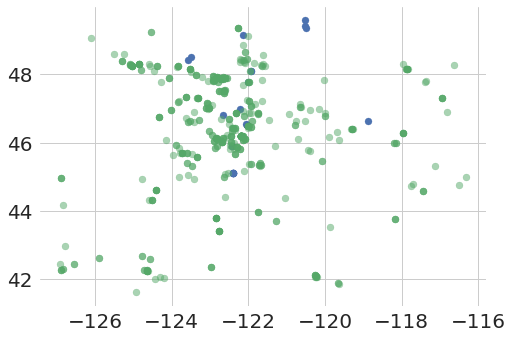

In [183]:
plt.scatter(miss_exp['source_longitude_deg'].values, miss_exp['source_latitude_deg'].values)
plt.scatter(miss_eq['source_longitude_deg'].values, miss_eq['source_latitude_deg'].values, alpha = 0.5)

## Plotting misclassified earthquakes

In [105]:
## Finding mislabelled events for each class
miss_exp = misclassified_X[misclassified_X['source_type'] == 'explosion']
miss_eq = misclassified_X[misclassified_X['source_type'] == 'earthquake']
miss_su = misclassified_X[misclassified_X['source_type'] == 'surface event']
miss_no = misclassified_X[misclassified_X['source_type'] == 'noise']

miss_eq = miss_eq[25:50]

## extracting data
p_arrivals= miss_eq['trace_P_arrival_sample'].values  ## We have P arrivals for the comcat events. 
buck_eq = [miss_eq['trace_name'].values[i].split('$')[0] for i in range(len(miss_eq))]
ind_eq = [int(miss_eq['trace_name'].values[i].split('$')[1].split(',')[0]) for i in range(len(miss_eq))]


## loading the data
data_eq = []
for i in range(len(buck_eq)):
    data_eq.append(comcat_file_name['/data/'+buck_eq[i]][ind_eq[i], 2, :15000])
    

## Processing the data
## This is to show the input before extracting features. 
data_eq = np.array(data_eq)

# Applying 10% cosine taper
tapered_eq = apply_cosine_taper(data_eq)

# Applying bandpass filter 1-10 Hz. (4 cornered)
final_eq = butterworth_filter(tapered_eq, 1, 10, 100, 4)

# Normalizing the data to remove the instrumental effect
norm_eq = final_eq/np.max(abs(np.array(final_eq)), axis = 1).reshape(-1,1)




## Assigning colors to each event id
# Example list of unique values
unique_values = miss_eq['event_id'].values# Your list here

# Choose a color palette
palette = sns.color_palette("dark", n_colors=len(unique_values))

# Create a mapping of unique values to colors
value_to_color = {value: color for value, color in zip(unique_values, palette)}

# Assign colors to the values
colors_list = [value_to_color[value] for value in unique_values]



labels = ['earthquake','explosion','noise','surface events']



## Assigned class and the probability
miss_eq_probs = np.max(miss_eq.iloc[:,481:485], axis = 1)
numerical_labels = np.argmax(miss_eq.iloc[:,481:485].values, axis = 1)
cat_labels = [labels[numerical_labels[i]] for i in range(len(numerical_labels))]
miss_ids = miss_eq['event_id'].values
miss_stns = (miss_eq['station_network_code']+'.'+miss_eq['station_code']+'.'+miss_eq['station_channel_code']+'Z').values

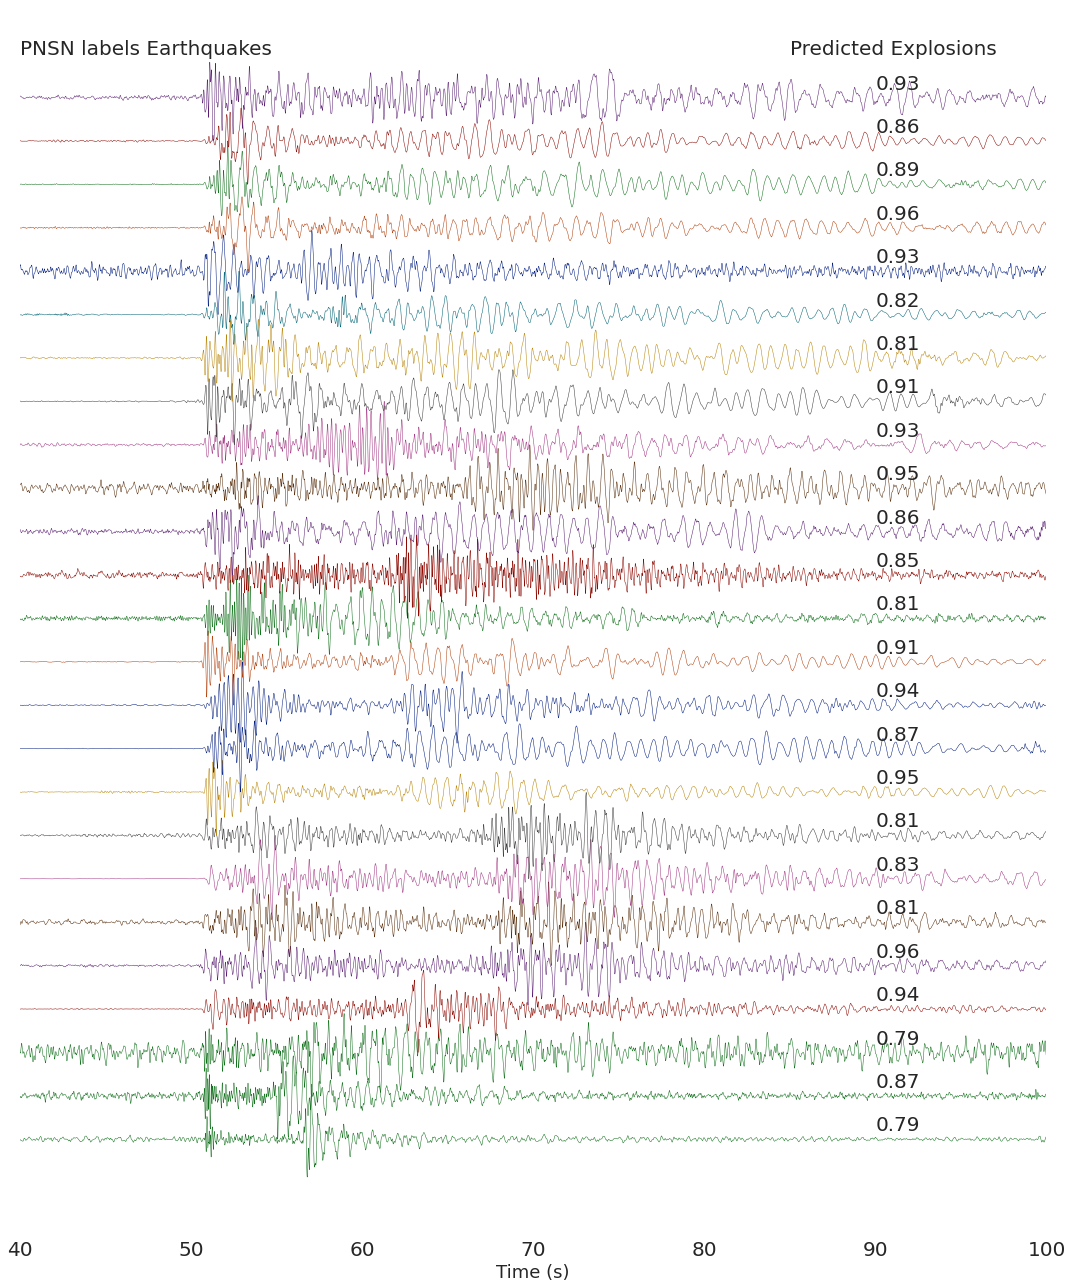

In [106]:

sns.set_style('whitegrid')

# Set rc parameters for font size
plt.rcParams['xtick.labelsize'] = 20  # Font size for xtick labels
plt.rcParams['ytick.labelsize'] = 20  # Font size for ytick labels
plt.rcParams['axes.labelsize'] = 18   # Font size for axis labels
plt.rcParams['axes.titlesize'] = 18   # Font size for title



# Create a figure and axes
fig, ax = plt.subplots(figsize=[15, 18])

# Plot the data with customized colors

for i in range(len(norm_eq)):
    t = np.linspace(1, len(np.array(norm_eq[i])[int(p_arrivals[i]) - 5000:])/100, len(np.array(norm_eq[i])[int(p_arrivals[i]) - 5000:]))
    ax.plot(t, np.array(norm_eq[i])[int(p_arrivals[i]) - 5000:] + i, lw=0.5, c=colors_list[i])
    ax.set_xlim(20, 90)
# Set y-axis labels
ax.set_yticks(ticks=np.arange(len(norm_eq)))
#ax.set_yticklabels(
#    labels=[miss_exp['source_type'].values[i] for i in range(len(miss_exp))],
#    fontsize = 15)

ax.set_yticks([])

# Set plot title and labels
#ax.set_title('Misclassified Explosions (px) with Mean Probabilities Exceeding 0.8', fontsize=25)
#ax.set_ylabel('PNSN labels Explosions', fontsize=25)
ax.grid(False)

# Create a twin axis on the right side
#ax2 = ax.twinx()
#ax2.set_yticks(np.arange(len(norm_exp)))
#ax2.set_yticklabels(
#    [cat_labels[i] + ', ' + str(np.around(miss_exp_probs[i], 2)) for i in range(len(miss_exp))], fontsize = 15
#   )

for i in range(len(miss_eq)):
    ax.text(90, i+0.2, str(np.around(miss_eq_probs[i],2)),  fontsize = 20)
ax.set_yticklabels([])


ax.text(85, 25, 'Predicted Explosions', fontsize = 20)
ax.text(40, 25, 'PNSN labels Earthquakes', fontsize = 20)
# Plot the data on the twin axis
#for i in range(len(norm_exp)):
    #t = np.linspace(1, len(np.array(norm_exp[i])[int(p_arrivals[i]) - 3000:])/100, len(np.array(norm_exp[i])[int(p_arrivals[i]) - 3000:]))
    #ax2.plot(t, np.array(norm_exp[i])[int(p_arrivals[i]) - 3000:] + i, lw=0.5, c=colors_list[i])
    #ax2.set_xlim(20)
# Set y-axis label for the twin axis
#ax2.set_ylabel('Predicted Earthquakes', fontsize=25)

# Adjust the positions of both y-axes for alignment
ax.spines['right'].set_visible(False)
#ax2.spines['left'].set_visible(False)
ax.yaxis.tick_left()
#ax2.yaxis.tick_right()
#ax2.tick_params(labelright=False)

# Set the location of y labels for the twin axis
#ax2.yaxis.set_label_position('right')
#ax2.yaxis.set_ticks_position('right')

ax.set_xlim(40, 100)
ax.set_xlabel('Time (s)')
# Remove grid lines
plt.grid(False)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Plotting misclassified noise

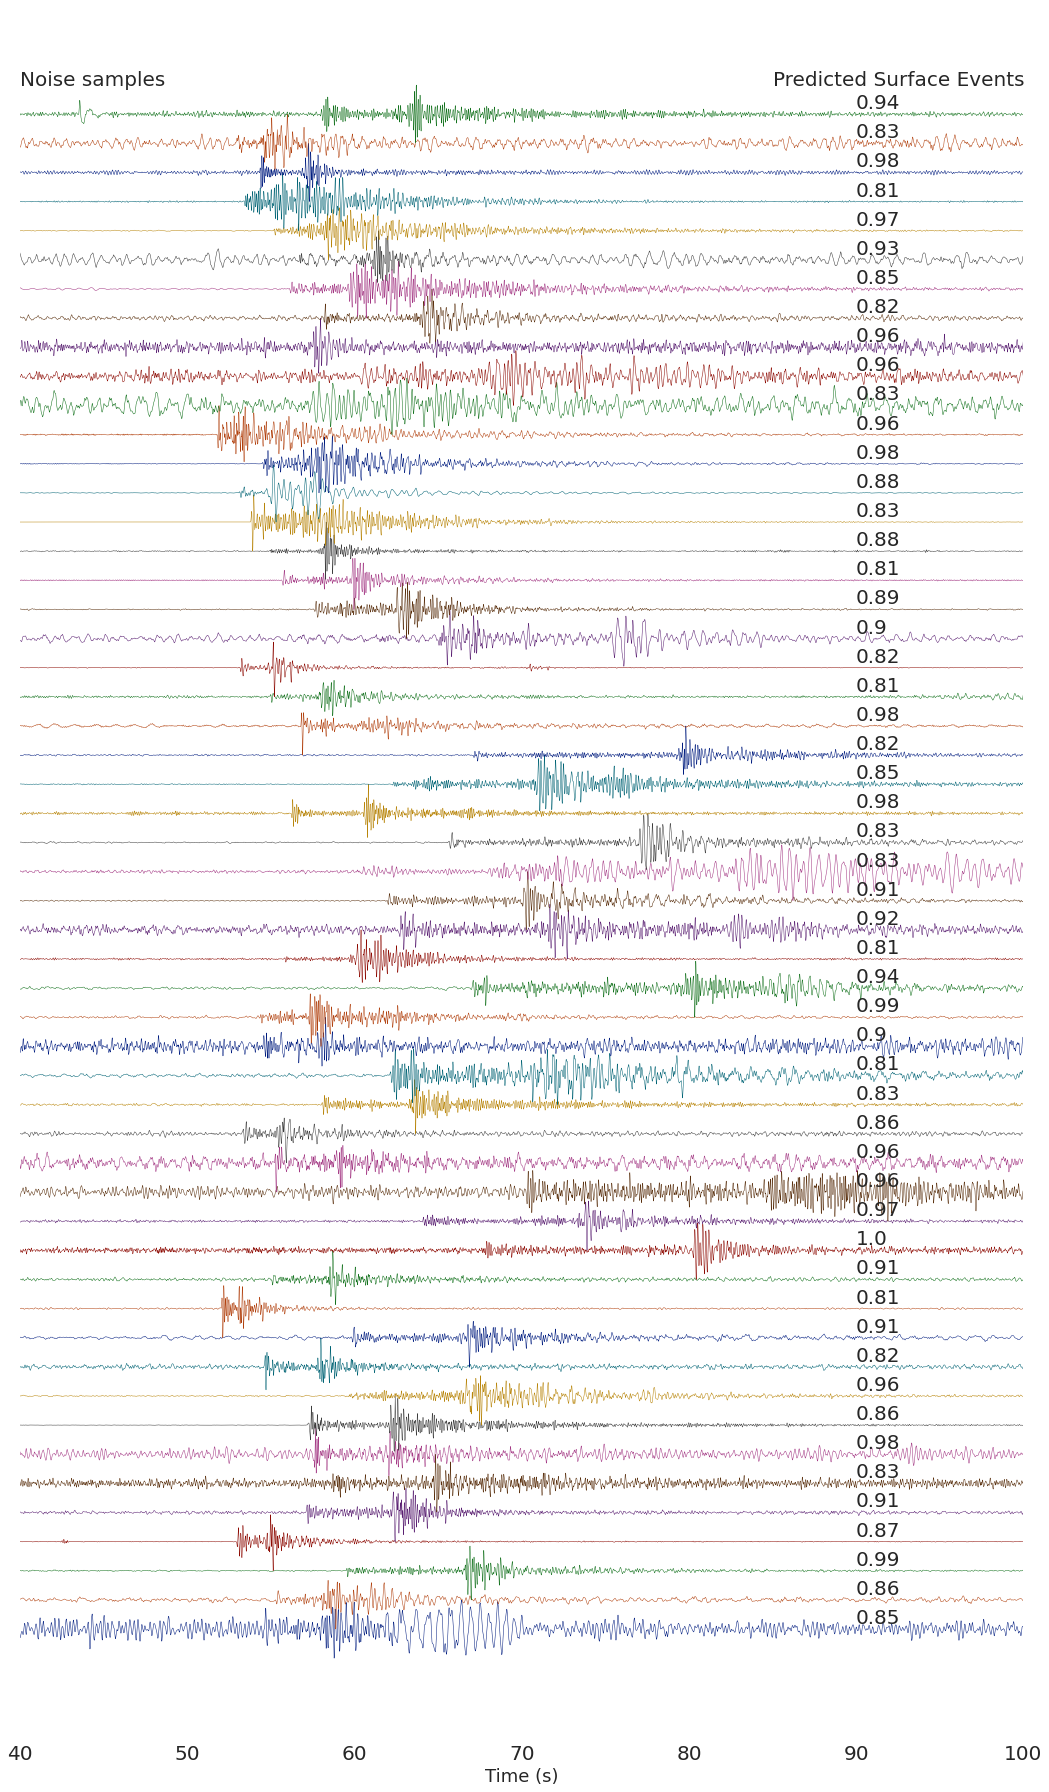

In [113]:
## Assigned class and the probability
miss_no_probs = np.max(miss_no.iloc[:,481:485], axis = 1)
## extracting data

buck_no = [miss_no['trace_name'].values[i].split('$')[0] for i in range(len(miss_no))]
ind_no = [int(miss_no['trace_name'].values[i].split('$')[1].split(',')[0]) for i in range(len(miss_no))]


## loading the data
data_no = []
for i in range(len(buck_no)):
    data_no.append(comcat_file_name['/data/'+buck_no[i]][ind_no[i], 2, :15000])
    

## Processing the data
## This is to show the input before extracting features. 
data_no = np.array(data_no)

# Applying 10% cosine taper
tapered_no = apply_cosine_taper(data_no)

# Applying bandpass filter 1-10 Hz. (4 cornered)
final_no = butterworth_filter(tapered_no, 1, 10, 100, 4)

# Normalizing the data to remove the instrumental effect
norm_no = final_no/np.max(abs(np.array(final_no)), axis = 1).reshape(-1,1)



## Assigning colors to each event id
# Example list of unique values
unique_values = miss_no['event_id'].values# Your list here


# Choose a color palette
palette = sns.color_palette("dark", n_colors=len(unique_values))

# Create a mapping of unique values to colors
value_to_color = {value: color for value, color in zip(unique_values, palette)}

# Assign colors to the values
colors_list = [value_to_color[value] for value in unique_values]



labels = ['earthquake','explosion','noise','surface events']






sns.set_style('whitegrid')

# Set rc parameters for font size
plt.rcParams['xtick.labelsize'] = 20  # Font size for xtick labels
plt.rcParams['ytick.labelsize'] = 20  # Font size for ytick labels
plt.rcParams['axes.labelsize'] = 18   # Font size for axis labels
plt.rcParams['axes.titlesize'] = 18   # Font size for title



# Create a figure and axes
fig, ax = plt.subplots(figsize=[15, 25])

# Plot the data with customized colors

for i in range(len(norm_no)):
    t = np.linspace(1, len(np.array(norm_no[i]))/100, len(np.array(norm_no[i])))
    ax.plot(t, np.array(norm_no[i]) + i, lw=0.5, c=colors_list[i])
    ax.set_xlim(20, 90)
# Set y-axis labels
ax.set_yticks(ticks=np.arange(len(norm_no)))
#ax.set_yticklabels(
#    labels=[miss_exp['source_type'].values[i] for i in range(len(miss_exp))],
#    fontsize = 15)

ax.set_yticks([])

# Set plot title and labels
#ax.set_title('Misclassified Explosions (px) with Mean Probabilities Exceeding 0.8', fontsize=25)
#ax.set_ylabel('PNSN labels Explosions', fontsize=25)
ax.grid(False)

# Create a twin axis on the right side
#ax2 = ax.twinx()
#ax2.set_yticks(np.arange(len(norm_exp)))
#ax2.set_yticklabels(
#    [cat_labels[i] + ', ' + str(np.around(miss_exp_probs[i], 2)) for i in range(len(miss_exp))], fontsize = 15
#   )

for i in range(len(miss_no)):
    ax.text(90, i+0.2, str(np.around(miss_no_probs[i],2)),  fontsize = 20)
ax.set_yticklabels([])


ax.text(85, 53, 'Predicted Surface Events', fontsize = 20)
ax.text(40, 53, 'Noise samples', fontsize = 20)
# Plot the data on the twin axis
#for i in range(len(norm_exp)):
    #t = np.linspace(1, len(np.array(norm_exp[i])[int(p_arrivals[i]) - 3000:])/100, len(np.array(norm_exp[i])[int(p_arrivals[i]) - 3000:]))
    #ax2.plot(t, np.array(norm_exp[i])[int(p_arrivals[i]) - 3000:] + i, lw=0.5, c=colors_list[i])
    #ax2.set_xlim(20)
# Set y-axis label for the twin axis
#ax2.set_ylabel('Predicted Earthquakes', fontsize=25)

# Adjust the positions of both y-axes for alignment
ax.spines['right'].set_visible(False)
#ax2.spines['left'].set_visible(False)
ax.yaxis.tick_left()
#ax2.yaxis.tick_right()
#ax2.tick_params(labelright=False)

# Set the location of y labels for the twin axis
#ax2.yaxis.set_label_position('right')
#ax2.yaxis.set_ticks_position('right')

ax.set_xlim(40, 100)
ax.set_xlabel('Time (s)')
# Remove grid lines
plt.grid(False)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Plotting the event depth distribution of the misclassified event catalog

/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


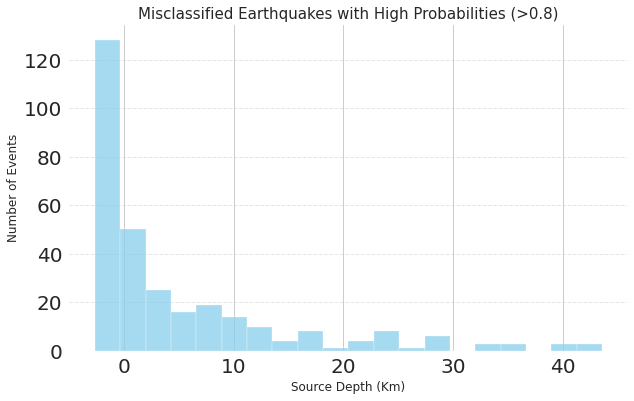

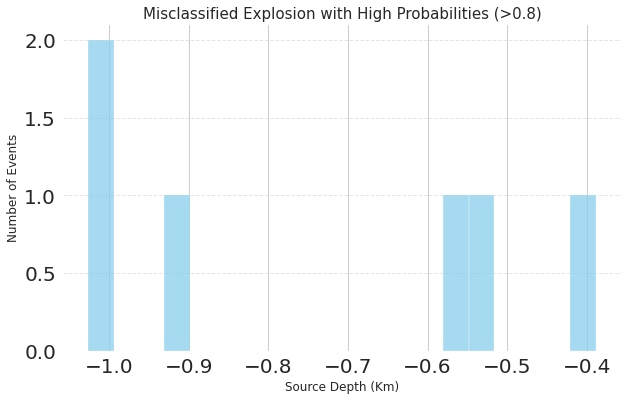

In [154]:
miss_eq['event_id'] = miss_eq.index.values
plt.figure(figsize=(10, 6))
sns.histplot(data=miss_eq.groupby('event_id').mean()['source_depth_km'], bins=20, kde=False, color='skyblue')
plt.xlabel('Source Depth (Km)', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.title('Misclassified Earthquakes with High Probabilities (>0.8)', fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()



miss_exp['event_id'] = miss_exp.index.values
plt.figure(figsize=(10, 6))
sns.histplot(data=miss_exp.groupby('event_id').mean()['source_depth_km'], bins=20, kde=False, color='skyblue')
plt.xlabel('Source Depth (Km)', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.title('Misclassified Explosion with High Probabilities (>0.8)', fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## Computing the distance from the nearest mine/quarry location 

The list may not be very complete but we will work with what we have. 

In [184]:
# Open the text file for reading and the CSV file for writing
with open('../Common_Scripts/Quarry_Locations.txt', 'r') as infile, open('../Common_Scripts/Quarry_Location.csv', 'w', newline='') as outfile:
    # Create a CSV writer object
    csv_writer = csv.writer(outfile)
    
    # Iterate over each line in the text file
    for line in infile:
        # Split the line into fields using comma as the delimiter
        fields = line.strip().split(',')
        # Write the fields to the CSV file
        csv_writer.writerow(fields)


In [186]:
from math import radians, sin, cos, sqrt, atan2

def calculate_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    # Radius of the Earth in kilometers
    R = 6371.0
    
    # Calculate the difference in latitude and longitude
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Calculate the distance using the Haversine formula
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    # Distance in kilometers
    distance = R * c
    
    return distance


In [190]:
data

{'latitude': array([ 48.062,  47.888,  47.815,  48.752,  48.477,  49.132,  49.288,
         49.028,  49.071,  49.132,  49.196,  48.895,  47.578,  47.707,
         48.864,  48.095,  48.089,  47.848,  47.535,  47.555,  47.55 ,
         47.509,  47.297,  47.226,  47.109,  47.107,  47.079,  46.981,
         46.876,  47.109,  47.142,  47.017,  46.85 ,  46.657,  46.585,
         46.539,  46.354,  46.183,  46.202,  46.121,  46.841,  46.511,
         45.817,  45.798,  46.618,  45.644,  44.587,  44.354,  40.724,
         42.439,  42.473,  43.083,  43.441,  43.639,  43.733,  44.121,
         44.257,  44.39 ,  44.579,  44.613,  44.7  ,  44.879,  44.949,
         44.409,  45.102,  45.114,  45.414,  45.155,  45.24 ,  45.243,
         45.341,  45.452,  45.356]),
 'longitude': array([-123.61 , -122.715, -122.909, -123.703, -123.501, -123.851,
        -122.657, -122.41 , -122.193, -122.179, -119.559, -117.788,
        -115.297, -117.539, -122.275, -121.939, -121.942, -122.027,
        -122.693, -122.7

In [191]:
## Reading the quarry locations
quarry_df = pd.read_csv('../Common_Scripts/Quarry_Location.csv', header = None)



miss_eq_lons = miss_eq.groupby('event_id').mean()['source_longitude_deg'].values
miss_eq_lats = miss_eq.groupby('event_id').mean()['source_latitude_deg'].values

miss_exp_lons = miss_exp.groupby('event_id').mean()['source_longitude_deg'].values
miss_exp_lats = miss_exp.groupby('event_id').mean()['source_latitude_deg'].values


# Sample DataFrame with latitude and longitude columns
data = {
    'latitude': quarry_df[1].values,
    'longitude': quarry_df[2].values
}
quarry_loc_df = pd.DataFrame(data)


min_quarry_eq = []

for i in range(len(miss_eq_lats)):
    # Given coordinate
    given_coord = (miss_eq_lats[i], miss_eq_lons[i])  # Example coordinate

 

    # Compute distance between given coordinate and all coordinates in the DataFrame
    dist = quarry_loc_df.apply(lambda row: calculate_distance(given_coord[0], given_coord[1], row['latitude'], row['longitude']), axis=1)


    
    # computing the distance of each event from the closest quarry
    min_quarry_eq.append(np.min(dist))


    
    
min_quarry_exp = []

for i in range(len(miss_exp_lats)):
    # Given coordinate
    given_coord = (miss_exp_lats[i], miss_exp_lons[i])  # Example coordinate

    # Compute distance between given coordinate and all coordinates in the DataFrame
    dist = quarry_loc_df.apply(lambda row: calculate_distance(given_coord[0], given_coord[1], row['latitude'], row['longitude']), axis=1)
    
    # computing the distance of each event from the closest quarry
    min_quarry_exp.append(np.min(dist))


## Plotting the distance from nearest quarry

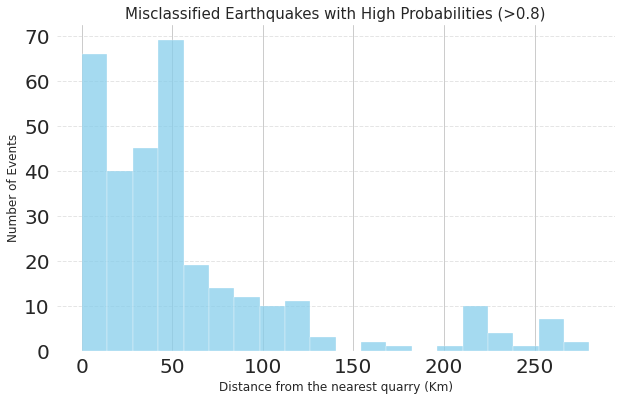

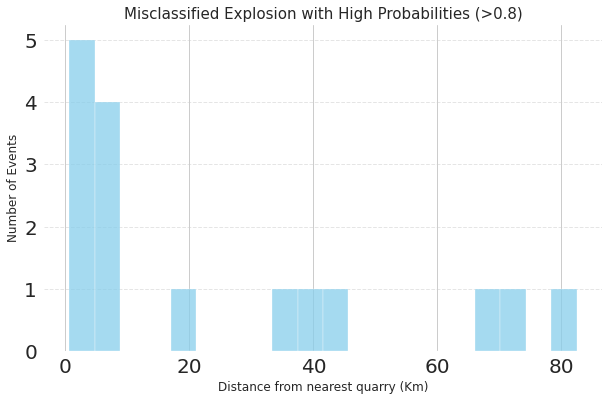

In [192]:
plt.figure(figsize=(10, 6))
sns.histplot(data= min_quarry_eq, bins=20, kde=False, color='skyblue')
plt.xlabel('Distance from the nearest quarry (Km)', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.title('Misclassified Earthquakes with High Probabilities (>0.8)', fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()




plt.figure(figsize=(10, 6))
sns.histplot(data= min_quarry_exp, bins=20, kde=False, color='skyblue')
plt.xlabel('Distance from nearest quarry (Km)', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.title('Misclassified Explosion with High Probabilities (>0.8)', fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [195]:
len(min_quarry_eq)

317

In [196]:
miss_eq.groupby('event_id').mean()

RappMaxMean  RappMaxMedian     AsDec  KurtoSig  KurtoEnv  \
event_id                                                               
uw10551388     0.191744       0.612855  0.629368 -0.116638 -0.348661   
uw10557603    -0.428248      -0.288366 -0.167701 -0.427539 -0.509259   
uw10560933    -0.561195      -0.248056  0.097545 -0.689088 -0.830788   
uw10564588     0.563357       0.094596 -0.267269  0.387207 -0.014329   
uw10577278    -0.579785      -0.322107 -0.083911 -0.566805 -0.650115   
...                 ...            ...       ...       ...       ...   
uw61847076     0.284951       0.682812 -0.138794 -0.121427 -0.434003   
uw61864457    -0.742945      -0.274300 -0.164803 -0.693620 -0.870283   
uw61880886    -0.354749      -0.215559 -0.301553 -0.425803 -0.566967   
uw61881697    -0.701936      -0.351337 -0.019930 -0.610533 -0.658997   
uw61886406    -0.025402       0.030373 -0.315292 -0.305176 -0.567099   

             SkewSig   SkewEnv  CorPeakNumber  Energy1/3Cor  Energy2/3Cor  \
event_id                                                                    
uw10551388 -0.904873 -0.110984      -1.891645     -0.203681      0.258672   
uw10557603 -0.142031 -0.261305      -1.614596      0.268979      0.364601   
uw10560933  0.194750 -0.872888      -1.091055      0.001368      0.019954   
uw10564588  2.221874  0.519925      -2.054614     -0.086547      0.242326   
uw10577278 -0.046247 -0.484347      -1.304953      0.092103     -0.088552   
...              ...       ...            ...           ...           ...   
uw61847076 -0.048389 -0.073158      -1.292730      0.053898     -0.017302   
uw61864457 -0.410356 -0.889741      -2.022020      2.207996     -2.464126   
uw61880886  0.090604 -0.328258      -1.129761     -0.001266     -0.007570   
uw61881697 -0.084425 -0.551634      -1.019756      0.285353     -0.112205   
uw61886406  0.103658 -0.236279      -1.036053      0.127974     -0.026189   

            int_ratio  E_0.1_1     E_1_3    E_3_10   E_10_20   E_20_50  \
event_id                                                                 
uw10551388  -0.013563      0.0  0.100738 -0.791365 -1.773147 -0.002416   
uw10557603   0.058179      0.0  0.617071 -0.237653 -0.326861 -0.002416   
uw10560933  -0.036872      0.0  0.586698  0.433338  0.071196 -0.002416   
uw10564588   0.006578      0.0 -0.279819 -1.507805 -2.142607 -0.002416   
uw10577278  -0.014278      0.0  0.639349  0.424606 -0.031810 -0.002416   
...               ...      ...       ...       ...       ...       ...   
uw61847076  -0.051276      0.0 -0.082540 -0.826268 -1.770292 -0.002416   
uw61864457  -0.015470      0.0  1.167594  0.148194 -0.516519 -0.002416   
uw61880886  -0.066682      0.0  0.226084  0.172574 -0.557596 -0.002416   
uw61881697   0.008403      0.0  0.851688  0.393115 -0.112662 -0.002416   
uw61886406  -0.122781      0.0 -0.106695 -0.207538 -0.688654 -0.002416   

            Kurt_0.1_1  Kurt_1_3  Kurt_3_10  Kurt_10_20  Kurt_20_50  \
event_id                                                              
uw10551388         0.0  0.756604  -0.467557   -0.575320         0.0   
uw10557603         0.0 -0.048657   0.422883   -0.525729         0.0   
uw10560933         0.0 -0.466596  -0.750179   -0.775474         0.0   
uw10564588         0.0  1.617525   0.742183   -0.160150         0.0   
uw10577278         0.0 -0.069805  -0.613153   -0.844012         0.0   
...                ...       ...        ...         ...         ...   
uw61847076         0.0  0.721115  -0.173772   -0.174716         0.0   
uw61864457         0.0 -0.402210  -0.687518    0.158345         0.0   
uw61880886         0.0  0.051349  -0.539690   -0.730934         0.0   
uw61881697         0.0 -0.057811  -0.790681   -0.930111         0.0   
uw61886406         0.0  0.336889  -0.393624   -0.116325         0.0   

            RMSDecPhaseLine   MeanFFT    MaxFFT   FMaxFFT  MedianFFT  \
event_id                                                               
uw10551388         0.413840 -0.628235 -0.1

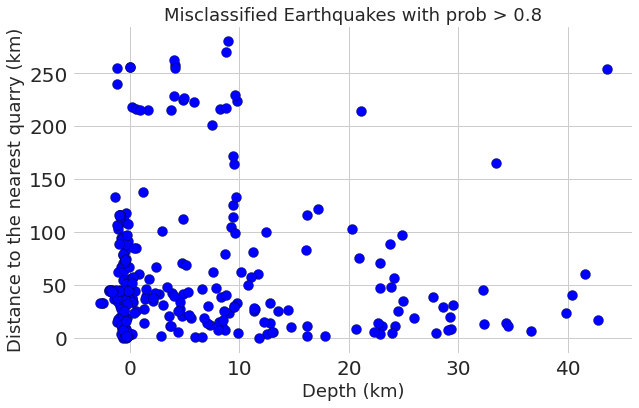

In [251]:
import matplotlib.pyplot as plt

# Scatter plot with prettified features
plt.figure(figsize=(10, 6))
plt.scatter(miss_eq.groupby('event_id').mean()['source_depth_km'], min_quarry_eq, s = 100, color='b', marker='o', edgecolor = 'k', edgecolors='k')
plt.xlabel('Depth (km)')
plt.ylabel('Distance to the nearest quarry (km)')
plt.title('Misclassified Earthquakes with prob > 0.8')
plt.grid(True)
plt.show()



In [206]:
mean_miss_eq = miss_eq.groupby('event_id').mean()
mean_miss_eq['dist_to_quarry'] = min_quarry_eq

In [211]:
## Finding for which earthquakes depth < 10 km and distance to quarry < 50 Km. 
sample_miss_eq = mean_miss_eq[(mean_miss_eq['source_depth_km'] < 10) & (mean_miss_eq['dist_to_quarry'] < 50) ]

In [219]:
new_miss_eq = miss_eq.loc[sample_miss_eq.index.values]

RappMaxMean  RappMaxMedian     AsDec  KurtoSig  KurtoEnv  \
uw10551388     0.191744       0.612855  0.629368 -0.116638 -0.348661   
uw10560933    -0.521593      -0.222861 -0.164258 -0.689591 -0.831717   
uw10560933    -0.600797      -0.273251  0.359348 -0.688584 -0.829860   
uw10564588     0.563357       0.094596 -0.267269  0.387207 -0.014329   
uw10577278    -0.579785      -0.322107 -0.083911 -0.566805 -0.650115   
...                 ...            ...       ...       ...       ...   
uw10729108    -0.708736      -0.369501 -0.124034 -0.590254 -0.413920   
uw10729108     0.190925       0.210006 -0.284046 -0.291960 -0.576363   
uw10729108    -0.497452      -0.324966  0.038445 -0.339824 -0.242212   
uw10732003     0.221185      -0.154469 -0.207695  0.291612  0.122371   
uw10732003     1.145426       0.661822 -0.306931  0.665012  0.170821   

             SkewSig   SkewEnv  CorPeakNumber  Energy1/3Cor  Energy2/3Cor  \
uw10551388 -0.904873 -0.110984      -1.891645     -0.203681      0.258672   
uw10560933 -0.104283 -0.874311      -0.730485     -0.165696      0.142809   
uw10560933  0.493782 -0.871464      -1.451626      0.168433     -0.102901   
uw10564588  2.221874  0.519925      -2.054614     -0.086547      0.242326   
uw10577278 -0.046247 -0.484347      -1.304953      0.092103     -0.088552   
...              ...       ...            ...           ...           ...   
uw10729108  0.224501 -0.300996      -1.932387      0.011070     -0.481119   
uw10729108  0.668919 -0.250065      -1.606447      0.103559     -0.055193   
uw10729108 -0.191961  0.010956      -1.696081     -0.064045      0.284167   
uw10732003 -1.623790  0.473422      -0.824192      0.015440     -0.009886   
uw10732003 -2.150021  0.669874      -1.948684      0.026429      0.013600   

            int_ratio  E_0.1_1     E_1_3    E_3_10   E_10_20   E_20_50  \
uw10551388  -0.013563     -0.0  0.100738 -0.791365 -1.773147 -0.002416   
uw10560933  -0.034169     -0.0  0.522837  0.557917  0.271944 -0.002416   
uw10560933  -0.039574     -0.0  0.650558  0.308759 -0.129552 -0.002416   
uw10564588   0.006578     -0.0 -0.279819 -1.507805 -2.142607 -0.002416   
uw10577278  -0.014278     -0.0  0.639349  0.424606 -0.031810 -0.002416   
...               ...      ...       ...       ...       ...       ...   
uw10729108   0.024190     -0.0  0.976502  0.415124 -0.870543 -0.002416   
uw10729108  -0.041660     -0.0  0.057198 -1.154658 -1.409865 -0.002416   
uw10729108   0.013063     -0.0  0.601058  0.007014 -0.139568 -0.002416   
uw10732003   0.004558     -0.0 -0.466001 -0.476790 -0.727824 -0.002416   
uw10732003   0.390141     -0.0 -0.457208 -1.624039 -3.188989 -0.002416   

            Kurt_0.1_1  Kurt_1_3  Kurt_3_10  Kurt_10_20  Kurt_20_50  \
uw10551388        -0.0  0.756604  -0.467557   -0.575320        -0.0   
uw10560933        -0.0 -0.535969  -0.705549   -0.735123        -0.0   
uw10560933        -0.0 -0.397222  -0.794809   -0.815825        -0.0   
uw10564588        -0.0  1.617525   0.742183   -0.160150        -0.0   
uw10577278        -0.0 -0.069805  -0.613153   -0.844012        -0.0   
...                ...       ...        ...         ...         ...   
uw10729108        -0.0 -0.275401  -0.494173   -0.023633        -0.0   
uw10729108        -0.0  0.312594   0.036563    0.869500        -0.0   
uw10729108        -0.0  0.683734  -0.740455   -0.941408        -0.0   
uw10732003        -0.0  2.801630  -0.439678   -0.906588        -0.0   
uw10732003        -0.0  2.067420   0.727240    0.120411        -0.0   

            RMSDecPhaseLine   MeanFFT    MaxFFT   FMaxFFT  MedianFFT  \
uw10551388         0.413840 -0.628235 -0.190064 -0.701920  -0.694589   
uw10560933        -0.070851  0.370908 -0.152587 -0.474208  -0.447973   
uw10560933         0.124148 -0.087116  0.108470 -0.373003  -0.351024   
uw10564588        -0.242776 -0.763779 -0.198565 -1.191078  -0.757991   
uw10577278        -0.130017  0.012128  0.356679 -0.268987   0.146232   
...                     ...       ...       ... 

In [225]:
## Finding mislabelled events for each class
miss_exp = misclassified_X[misclassified_X['source_type'] == 'explosion']
miss_eq = misclassified_X[misclassified_X['source_type'] == 'earthquake']
miss_su = misclassified_X[misclassified_X['source_type'] == 'surface event']
miss_no = misclassified_X[misclassified_X['source_type'] == 'noise']

miss_eq = new_miss_eq[0:50]

## extracting data
p_arrivals= miss_eq['trace_P_arrival_sample'].values  ## We have P arrivals for the comcat events. 
buck_eq = [miss_eq['trace_name'].values[i].split('$')[0] for i in range(len(miss_eq))]
ind_eq = [int(miss_eq['trace_name'].values[i].split('$')[1].split(',')[0]) for i in range(len(miss_eq))]


## loading the data
data_eq = []
for i in range(len(buck_eq)):
    data_eq.append(comcat_file_name['/data/'+buck_eq[i]][ind_eq[i], 2, :15000])
    

## Processing the data
## This is to show the input before extracting features. 
data_eq = np.array(data_eq)

# Applying 10% cosine taper
tapered_eq = apply_cosine_taper(data_eq)

# Applying bandpass filter 1-10 Hz. (4 cornered)
final_eq = butterworth_filter(tapered_eq, 1, 10, 100, 4)

# Normalizing the data to remove the instrumental effect
norm_eq = final_eq/np.max(abs(np.array(final_eq)), axis = 1).reshape(-1,1)




## Assigning colors to each event id
# Example list of unique values
unique_values = miss_eq['event_id'].values# Your list here

# Choose a color palette
palette = sns.color_palette("dark", n_colors=len(unique_values))

# Create a mapping of unique values to colors
value_to_color = {value: color for value, color in zip(unique_values, palette)}

# Assign colors to the values
colors_list = [value_to_color[value] for value in unique_values]



labels = ['earthquake','explosion','noise','surface events']



## Assigned class and the probability
miss_eq_probs = np.max(miss_eq.iloc[:,481:485], axis = 1)
numerical_labels = np.argmax(miss_eq.iloc[:,481:485].values, axis = 1)
cat_labels = [labels[numerical_labels[i]] for i in range(len(numerical_labels))]
miss_ids = miss_eq['event_id'].values
miss_stns = (miss_eq['station_network_code']+'.'+miss_eq['station_code']+'.'+miss_eq['station_channel_code']+'Z').values

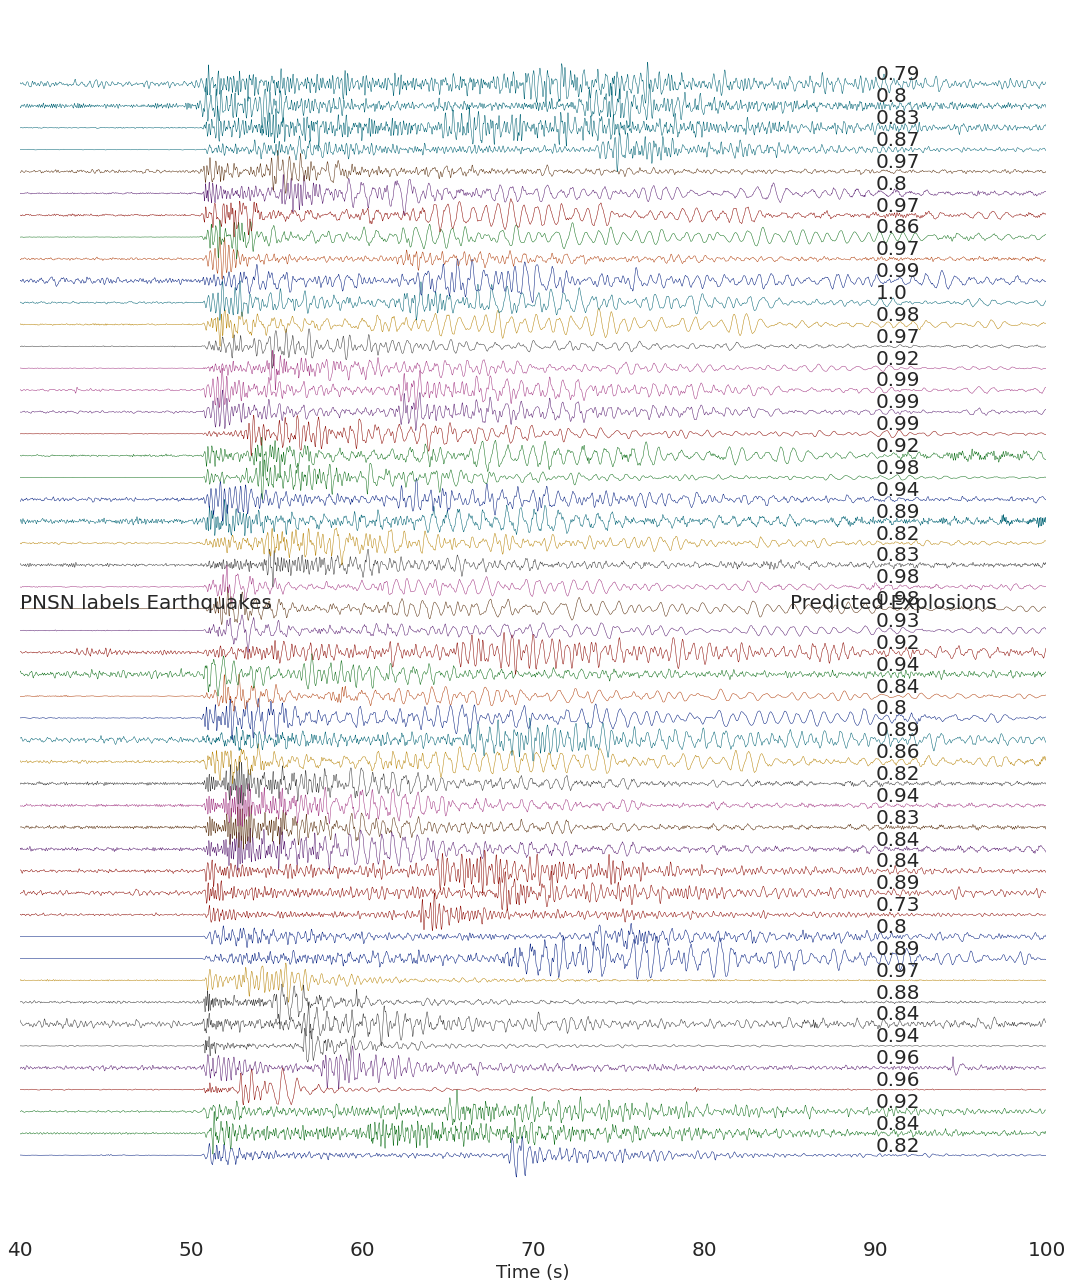

In [226]:

sns.set_style('whitegrid')

# Set rc parameters for font size
plt.rcParams['xtick.labelsize'] = 20  # Font size for xtick labels
plt.rcParams['ytick.labelsize'] = 20  # Font size for ytick labels
plt.rcParams['axes.labelsize'] = 18   # Font size for axis labels
plt.rcParams['axes.titlesize'] = 18   # Font size for title



# Create a figure and axes
fig, ax = plt.subplots(figsize=[15, 18])

# Plot the data with customized colors

for i in range(len(norm_eq)):
    t = np.linspace(1, len(np.array(norm_eq[i])[int(p_arrivals[i]) - 5000:])/100, len(np.array(norm_eq[i])[int(p_arrivals[i]) - 5000:]))
    ax.plot(t, np.array(norm_eq[i])[int(p_arrivals[i]) - 5000:] + i, lw=0.5, c=colors_list[i])
    ax.set_xlim(20, 90)
# Set y-axis labels
ax.set_yticks(ticks=np.arange(len(norm_eq)))
#ax.set_yticklabels(
#    labels=[miss_exp['source_type'].values[i] for i in range(len(miss_exp))],
#    fontsize = 15)

ax.set_yticks([])

# Set plot title and labels
#ax.set_title('Misclassified Explosions (px) with Mean Probabilities Exceeding 0.8', fontsize=25)
#ax.set_ylabel('PNSN labels Explosions', fontsize=25)
ax.grid(False)

# Create a twin axis on the right side
#ax2 = ax.twinx()
#ax2.set_yticks(np.arange(len(norm_exp)))
#ax2.set_yticklabels(
#    [cat_labels[i] + ', ' + str(np.around(miss_exp_probs[i], 2)) for i in range(len(miss_exp))], fontsize = 15
#   )

for i in range(len(miss_eq)):
    ax.text(90, i+0.2, str(np.around(miss_eq_probs[i],2)),  fontsize = 20)
ax.set_yticklabels([])


ax.text(85, 25, 'Predicted Explosions', fontsize = 20)
ax.text(40, 25, 'PNSN labels Earthquakes', fontsize = 20)
# Plot the data on the twin axis
#for i in range(len(norm_exp)):
    #t = np.linspace(1, len(np.array(norm_exp[i])[int(p_arrivals[i]) - 3000:])/100, len(np.array(norm_exp[i])[int(p_arrivals[i]) - 3000:]))
    #ax2.plot(t, np.array(norm_exp[i])[int(p_arrivals[i]) - 3000:] + i, lw=0.5, c=colors_list[i])
    #ax2.set_xlim(20)
# Set y-axis label for the twin axis
#ax2.set_ylabel('Predicted Earthquakes', fontsize=25)

# Adjust the positions of both y-axes for alignment
ax.spines['right'].set_visible(False)
#ax2.spines['left'].set_visible(False)
ax.yaxis.tick_left()
#ax2.yaxis.tick_right()
#ax2.tick_params(labelright=False)

# Set the location of y labels for the twin axis
#ax2.yaxis.set_label_position('right')
#ax2.yaxis.set_ticks_position('right')

ax.set_xlim(40, 100)
ax.set_xlabel('Time (s)')
# Remove grid lines
plt.grid(False)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Retraining the catalog after removing the potentially mislabeled events (Events that were misclassified with high probability)

In this following block, I am picking 5000 random "events" (based on the event ids) from each class and puttiing them into training dataset and putting the rest into testing dataset. 




In [281]:
## extracting metadata information for each kind of source along with features
a_eq = X_final[X_final['source_type_pnsn_label'] == 'eq']
a_px = X_final[X_final['source_type_pnsn_label'] == 'px']
a_su = X_final[X_final['source_type'] == 'surface event']
a_no = X_final[X_final['source_type'] == 'noise']



## extracting the event ids corresponding to each catalog
eq_ids = np.unique(a_eq['event_id'].values)
su_ids = np.unique(a_su['event_id'].values)
no_ids = np.unique(a_no['event_id'].values)
px_ids = np.unique(a_px['event_id'].values)


## defining the events for training and testing in 70:30 ratio


"""

Modifying this section a bit, for a fair comparison to deep neural network. 


train_eq = eq_ids[0:int(0.7*len(eq_ids))]
train_px = px_ids[0:int(0.7*len(px_ids))]
train_su = su_ids[0:int(0.7*len(su_ids))]
train_no = no_ids[0:int(0.7*len(no_ids))]


test_eq = eq_ids[int(0.7*len(eq_ids)):len(eq_ids)]
test_px = px_ids[int(0.7*len(px_ids)):len(px_ids)]
test_su = su_ids[int(0.7*len(su_ids)):len(su_ids)]
test_no = no_ids[int(0.7*len(no_ids)):len(no_ids)]


"""

## randomizing along the time. 
r1 = np.random.randint(0, len(eq_ids), 5000)
train_eq = eq_ids[r1]

## randomizing along the time. 
r2 = np.random.randint(0, len(px_ids), 5000)
train_px = px_ids[r2]

## randomizing along the time. 
r3 = np.random.randint(0, len(su_ids), 5000)
train_su = su_ids[r3]

## randomizing along the time
r4 = np.random.randint(0, len(no_ids), 5000)
train_no = no_ids[r4]



mask_eq = np.ones(eq_ids.shape, dtype = bool)
mask_eq[r1] = False

mask_px = np.ones(px_ids.shape, dtype = bool)
mask_px[r2] = False

mask_su = np.ones(su_ids.shape, dtype = bool)
mask_su[r3] = False

mask_no = np.ones(no_ids.shape, dtype = bool)
mask_no[r4] = False

test_eq = eq_ids[mask_eq]
test_px = px_ids[mask_px]
test_su = su_ids[mask_su]
test_no = no_ids[mask_no]



# concatenating training ids
all_train_ids = np.concatenate([train_eq,train_px, train_su, train_no])

# concatenating testing ids
all_test_ids = np.concatenate([test_eq,test_px, test_su, test_no])

# allocating event id as index
X_final.index = X_final['event_id'].values


# extracting training and testing values
X_train = X_final.loc[all_train_ids]
X_test = X_final.loc[all_test_ids]



Y_train = X_train['source_type'].values
Y_test = X_test['source_type'].values

## So initial strategy is to remove the events that were incorrectly classified with high probability (> 0.8) and retest the events

In [282]:
# Case 1: without adding anything manual
## Check the performance 
x_train = X_train.iloc[:, 0:437]
x_train = x_train.assign(hod=X_train['hour_of_day'].values, dow=X_train['day_of_week'].values, moy=X_train['month_of_year'].values)

x_test = X_test.iloc[:, 0:437]
x_test = x_test.assign(hod=X_test['hour_of_day'].values, dow=X_test['day_of_week'].values, moy=X_test['month_of_year'].values)






## Randomly sampling 5000 traces for each class in the training dataset, train the model on it and test on the remaining dataset

In [283]:
# initiating a random undersampler
rus = RandomUnderSampler(sampling_strategy={'earthquake':5000, 'explosion':5000,'surface event':5000,'noise':5000}, random_state = 42)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Converting the textual labels into numerical labels
y_num_test = label_encoder.fit_transform(Y_test)


# randomly taking 5000 samples per class from the training dataset
X_resampled, y_resampled = rus.fit_resample(x_train, Y_train)


# Fit the LabelEncoder on the text labels and transform them to numeric labels
y_num_res = label_encoder.fit_transform(y_resampled)



best_model.class_weight  = None
best_model.fit(X_resampled, y_num_res)

RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_split=5,
                       random_state=42)

## Trace wise performance

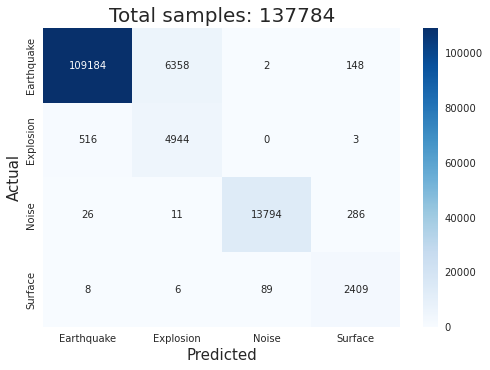

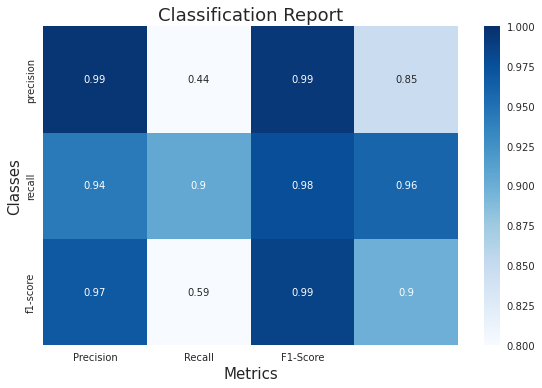

In [284]:
y_pred = best_model.predict(x_test)
plt.style.use('seaborn')
trace_cm_manual = confusion_matrix(y_num_test, y_pred)


labels = ['Earthquake', 'Explosion','Noise','Surface']

plt.figure()
sns.heatmap(trace_cm_manual, annot=True, cmap='Blues', fmt='d', xticklabels = labels, yticklabels = labels)
plt.xlabel('Predicted', fontsize = 15)
plt.ylabel('Actual', fontsize = 15)
plt.title('Total samples: '+str(len(y_pred)), fontsize = 20)



# Calculate the classification report
trace_report_manual = classification_report(y_num_test, y_pred, output_dict=True)
labels = ['Precision', 'Recall', 'F1-Score']

# Set a pleasing style
sns.set_style("whitegrid")

# Create a figure and axes for the heatmap
plt.figure()
ax = sns.heatmap(pd.DataFrame(trace_report_manual).iloc[:3, :4], annot=True, cmap='Blues', xticklabels=labels, vmin=0.8, vmax=1)

# Set labels and title
ax.set_xlabel('Metrics', fontsize=15)
ax.set_ylabel('Classes', fontsize=15)
ax.set_title('Classification Report', fontsize=18)

# Create a colorbar
#cbar = ax.collections[0].colorbar
#cbar.set_ticks([0.5, 1])  # Set custom tick locations
#cbar.set_ticklabels(['0', '0.5', '1'])  # Set custom tick labels

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Event wise performance

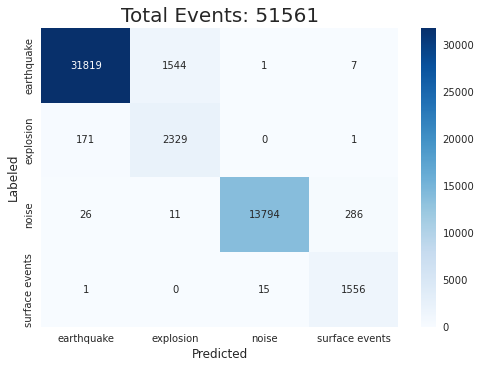

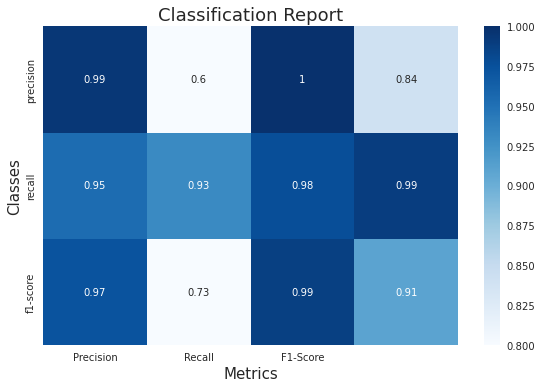

In [285]:
probs_all = best_model.predict_proba(x_test)

X_test['labelled'] = y_num_test
X_test['classified'] = y_pred
X_test['eq_probability'] = probs_all[:,0]
X_test['px_probability'] = probs_all[:,1]
X_test['no_probability'] = probs_all[:,2]
X_test['su_probability'] = probs_all[:,3]


mean_labels = X_test.groupby('event_id').mean()['labelled'].values
mean_ids = X_test.groupby('event_id').mean().index.values



mean_eq_prob = X_test.groupby('event_id').mean()['eq_probability'].values
mean_px_prob = X_test.groupby('event_id').mean()['px_probability'].values
mean_no_prob = X_test.groupby('event_id').mean()['no_probability'].values
mean_su_prob = X_test.groupby('event_id').mean()['su_probability'].values



temp_class = np.argmax(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)
temp_probs = np.max(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)



cf_events_manual = confusion_matrix(mean_labels, temp_class)
cf_norm_manual = cf_events_manual/np.sum(cf_events_manual, axis = 1, keepdims = True)
labels = ['earthquake','explosion','noise','surface events']

plt.figure()
ax = sns.heatmap(cf_events_manual, annot = True, cmap='Blues', xticklabels = labels, yticklabels = labels,  fmt="1.0f")
ax.set_xlabel('Predicted', fontsize = 12)
ax.set_ylabel('Labeled', fontsize = 12)
ax.set_title('Total Events: '+str(len(mean_labels)), fontsize = 20)





# Calculate the classification report
report_event_manual = classification_report(mean_labels, temp_class, output_dict=True)
labels = ['Precision', 'Recall', 'F1-Score']

# Set a pleasing style
sns.set_style("whitegrid")

# Create a figure and axes for the heatmap
plt.figure()
ax = sns.heatmap(pd.DataFrame(report_event_manual).iloc[:3, :4], annot=True, cmap='Blues', xticklabels=labels, vmin=0.8, vmax=1)

# Set labels and title
ax.set_xlabel('Metrics', fontsize=15)
ax.set_ylabel('Classes', fontsize=15)
ax.set_title('Classification Report', fontsize=18)

# Create a colorbar
#cbar = ax.collections[0].colorbar
#cbar.set_ticks([0.5, 1])  # Set custom tick locations
#cbar.set_ticklabels(['0', '0.5', '1'])  # Set custom tick labels

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Analysis of misclassified events

In [293]:
# probabilities corresponding to misclassified events
misclassified_probs = temp_probs[np.where(mean_labels != temp_class)]

# classification provided to misclassified events
misclassified_class = temp_class[np.where(mean_labels != temp_class)]

# labels provided to misclassified events. 
misclassified_labels = mean_labels[np.where(mean_labels != temp_class)]

# event ids provided to misclassified events. 
misclassified_ids = mean_ids[np.where(mean_labels != temp_class)]

# event ids from misclassified events where mean probabilities exceed 0.8
misclassified_high_prob = misclassified_ids[np.where(misclassified_probs > 0.7)]

misclassified_X = X_test.loc[misclassified_high_prob]



In [294]:
misclassified_high_prob

array(['noise11317', 'noise11503', 'noise12003', 'noise12539', 'noise127',
       'noise13332', 'noise13360', 'noise13825', 'noise1417', 'noise14267',
       'noise14710', 'noise15722', 'noise15763', 'noise16540',
       'noise16668', 'noise17497', 'noise183', 'noise18456', 'noise2127',
       'noise2205', 'noise299', 'noise3864', 'noise4316', 'noise4376',
       'noise4791', 'noise5170', 'noise5859', 'noise6554', 'noise7514',
       'noise7938', 'noise802', 'noise805', 'noise8658', 'noise9003',
       'noise922', 'pnsn1038648', 'pnsn890478', 'uw10551388', 'uw10551613',
       'uw10555268', 'uw10557083', 'uw10567278', 'uw10569868',
       'uw10576823', 'uw10580823', 'uw10583693', 'uw10584628',
       'uw10590118', 'uw10594953', 'uw10598863', 'uw10603943',
       'uw10605968', 'uw10610008', 'uw10613723', 'uw10613993',
       'uw10614788', 'uw10616553', 'uw10619993', 'uw10620068',
       'uw10620083', 'uw10620878', 'uw10621448', 'uw10624623',
       'uw10633198', 'uw10637218', 'uw1064153

## Retesting with potentially mislabeled events removed this time

In [295]:
new_X_test = X_test.drop(misclassified_high_prob)
new_x_test = new_X_test.iloc[:, 0:437]
new_x_test = new_x_test.assign(hod=new_X_test['hour_of_day'].values, dow=new_X_test['day_of_week'].values, moy= new_X_test['month_of_year'].values)

new_Y_test = new_X_test['source_type'].values

## New trace-wise performance

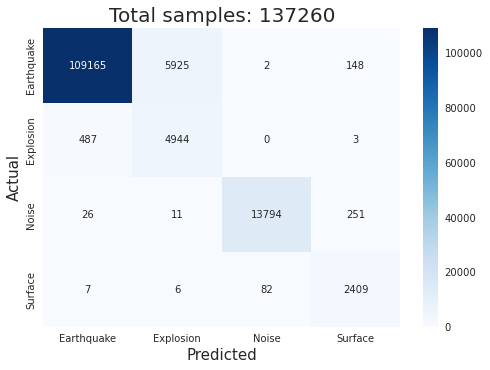

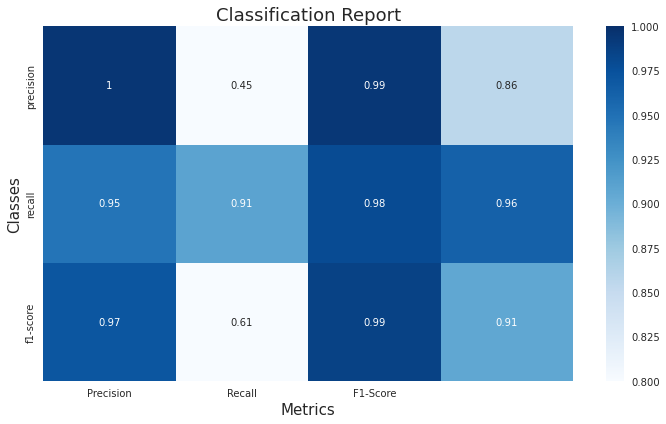

In [296]:
y_pred = best_model.predict(new_x_test)
plt.style.use('seaborn')


# Converting the textual labels into numerical labels
y_num_test = label_encoder.fit_transform(new_Y_test)

new_trace_cm_manual = confusion_matrix(y_num_test, y_pred)


labels = ['Earthquake', 'Explosion','Noise','Surface']
sns.heatmap(new_trace_cm_manual, annot=True, cmap='Blues', fmt='d', xticklabels = labels, yticklabels = labels)
plt.xlabel('Predicted', fontsize = 15)
plt.ylabel('Actual', fontsize = 15)
plt.title('Total samples: '+str(len(y_pred)), fontsize = 20)



# Calculate the classification report
new_trace_report_manual = classification_report(y_num_test, y_pred, output_dict=True)
labels = ['Precision', 'Recall', 'F1-Score']

# Set a pleasing style
sns.set_style("whitegrid")

# Create a figure and axes for the heatmap
plt.figure(figsize=(10, 6))
ax = sns.heatmap(pd.DataFrame(new_trace_report_manual).iloc[:3, :4], annot=True, cmap='Blues', xticklabels=labels, vmin=0.8, vmax=1)

# Set labels and title
ax.set_xlabel('Metrics', fontsize=15)
ax.set_ylabel('Classes', fontsize=15)
ax.set_title('Classification Report', fontsize=18)

# Create a colorbar
#cbar = ax.collections[0].colorbar
#cbar.set_ticks([0.5, 1])  # Set custom tick locations
#cbar.set_ticklabels(['0', '0.5', '1'])  # Set custom tick labels

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


# New event wise performance

/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


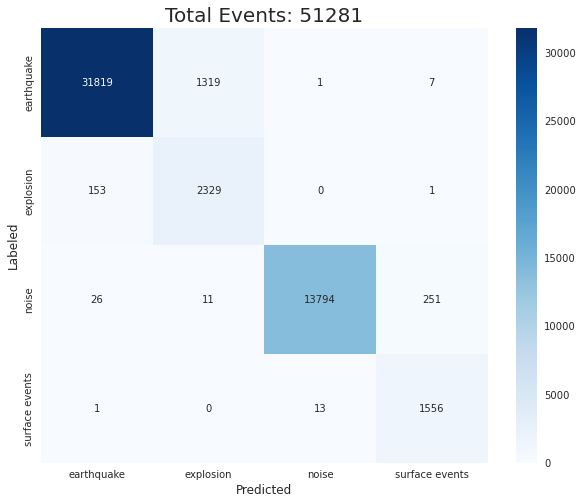

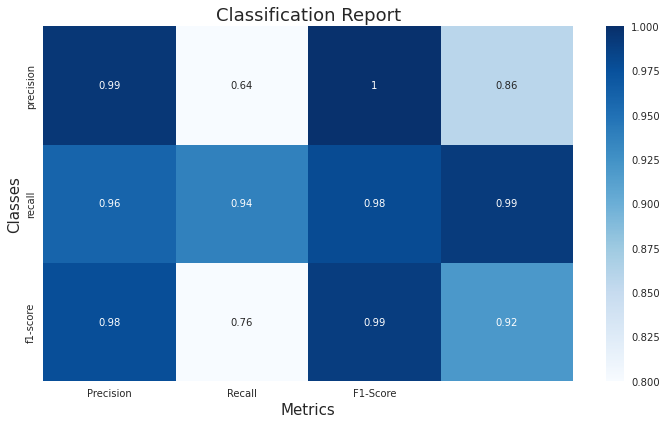

In [297]:
probs_all = best_model.predict_proba(new_x_test)

new_X_test['labelled'] = y_num_test
new_X_test['classified'] = y_pred
new_X_test['eq_probability'] = probs_all[:,0]
new_X_test['px_probability'] = probs_all[:,1]
new_X_test['no_probability'] = probs_all[:,2]
new_X_test['su_probability'] = probs_all[:,3]


mean_labels = new_X_test.groupby('event_id').mean()['labelled'].values
mean_ids = new_X_test.groupby('event_id').mean().index.values



mean_eq_prob = new_X_test.groupby('event_id').mean()['eq_probability'].values
mean_px_prob = new_X_test.groupby('event_id').mean()['px_probability'].values
mean_no_prob = new_X_test.groupby('event_id').mean()['no_probability'].values
mean_su_prob = new_X_test.groupby('event_id').mean()['su_probability'].values



temp_class = np.argmax(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)
temp_probs = np.max(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)



new_cf_events_manual = confusion_matrix(mean_labels, temp_class)
#new_cf_norm_manual = cf_events_manual/np.sum(cf_events_manual, axis = 1, keepdims = True)
labels = ['earthquake','explosion','noise','surface events']

plt.figure(figsize = [10,8])
ax = sns.heatmap(new_cf_events_manual, annot = True, cmap='Blues', xticklabels = labels, yticklabels = labels,  fmt="1.0f")
ax.set_xlabel('Predicted', fontsize = 12)
ax.set_ylabel('Labeled', fontsize = 12)
ax.set_title('Total Events: '+str(len(mean_labels)), fontsize = 20)





# Calculate the classification report
new_report_event_manual = classification_report(mean_labels, temp_class, output_dict=True)
labels = ['Precision', 'Recall', 'F1-Score']

# Set a pleasing style
sns.set_style("whitegrid")

# Create a figure and axes for the heatmap
plt.figure(figsize=(10, 6))
ax = sns.heatmap(pd.DataFrame(new_report_event_manual).iloc[:3, :4], annot=True, cmap='Blues', xticklabels=labels, vmin=0.8, vmax=1)

# Set labels and title
ax.set_xlabel('Metrics', fontsize=15)
ax.set_ylabel('Classes', fontsize=15)
ax.set_title('Classification Report', fontsize=18)

# Create a colorbar
#cbar = ax.collections[0].colorbar
#cbar.set_ticks([0.5, 1])  # Set custom tick locations
#cbar.set_ticklabels(['0', '0.5', '1'])  # Set custom tick labels

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Plotting the difference in performance before and after removing the potentially mislabeled events

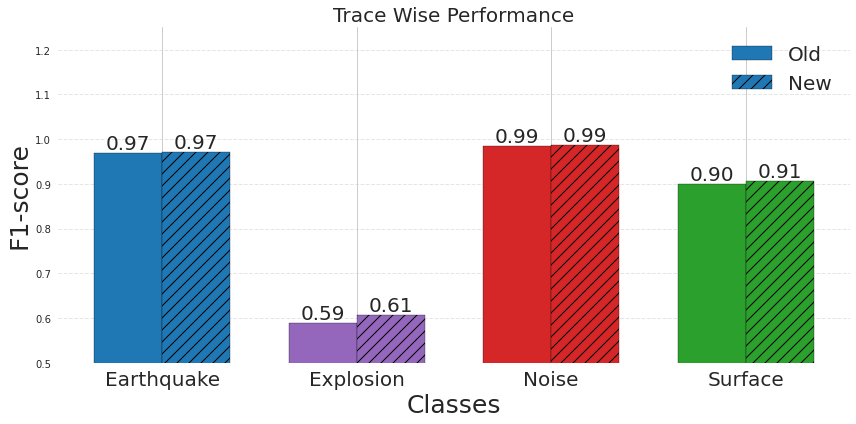

In [298]:
# Data for the first group
eq_trace_f1 = trace_report_manual['0']['f1-score']
exp_trace_f1 = trace_report_manual['1']['f1-score']
no_trace_f1 = trace_report_manual['2']['f1-score']
su_trace_f1 = trace_report_manual['3']['f1-score']

# Data for the second group
new_eq_trace_f1 = new_trace_report_manual['0']['f1-score']
new_exp_trace_f1 = new_trace_report_manual['1']['f1-score']
new_no_trace_f1 = new_trace_report_manual['2']['f1-score']
new_su_trace_f1 = new_trace_report_manual['3']['f1-score']

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(4)
r2 = [x + bar_width for x in r1]

# Plot the bars
# Colorblind-friendly palette
cb_palette = ['#1f77b4','#9467bd',   '#d62728',  '#2ca02c',  ]


plt.figure(figsize=(12, 6))
plt.bar(r1, [eq_trace_f1, exp_trace_f1, no_trace_f1, su_trace_f1], color= cb_palette, width=bar_width, edgecolor='k', label='Old')
plt.bar(r2, [new_eq_trace_f1, new_exp_trace_f1, new_no_trace_f1, new_su_trace_f1], color= cb_palette, hatch='//', width=bar_width, edgecolor='black', label='New')

# Add labels, title, and legend
plt.ylim(0.5,1.25)
plt.xlabel('Classes',  fontsize=25)
plt.ylabel('F1-score', fontsize=25)
plt.xticks([r + bar_width/2 for r in range(4)], ['Earthquake', 'Explosion', 'Noise', 'Surface'], fontsize=20)
#plt.title('F1-score by Class for Old and New', fontweight='bold', fontsize=14)
plt.legend(fontsize=20)

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add value labels on top of each bar
def add_value_labels(ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', ((p.get_x() + p.get_width() / 2), p.get_height()), ha='center', va='bottom', fontsize=20)

add_value_labels(plt.gca())

# Show plot
plt.title('Trace Wise Performance', fontsize = 20)
plt.tight_layout()
plt.show()


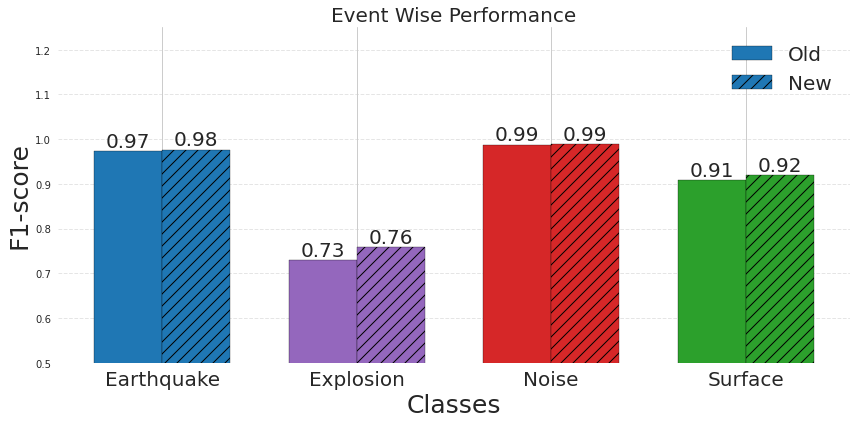

In [299]:
# Data for the first group
eq_trace_f1 = report_event_manual['0.0']['f1-score']
exp_trace_f1 = report_event_manual['1.0']['f1-score']
no_trace_f1 = report_event_manual['2.0']['f1-score']
su_trace_f1 = report_event_manual['3.0']['f1-score']

# Data for the second group
new_eq_trace_f1 = new_report_event_manual['0.0']['f1-score']
new_exp_trace_f1 = new_report_event_manual['1.0']['f1-score']
new_no_trace_f1 = new_report_event_manual['2.0']['f1-score']
new_su_trace_f1 = new_report_event_manual['3.0']['f1-score']

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(4)
r2 = [x + bar_width for x in r1]

# Plot the bars
plt.figure(figsize=(12, 6))
plt.bar(r1, [eq_trace_f1, exp_trace_f1, no_trace_f1, su_trace_f1], color= cb_palette, width=bar_width, edgecolor='black', label='Old')
plt.bar(r2, [new_eq_trace_f1, new_exp_trace_f1, new_no_trace_f1, new_su_trace_f1], color= cb_palette, hatch='//', width=bar_width, edgecolor='black', label='New')

# Add labels, title, and legend
plt.ylim(0.5, 1.25)
plt.xlabel('Classes',  fontsize= 25)
plt.ylabel('F1-score',  fontsize=25)
plt.xticks([r + bar_width/2 for r in range(4)], ['Earthquake', 'Explosion', 'Noise', 'Surface'], fontsize=20)
#plt.title('F1-score by Class for Old and New', fontweight='bold', fontsize=14)
plt.legend(fontsize=20)

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add value labels on top of each bar
def add_value_labels(ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', ((p.get_x() + p.get_width() / 2), p.get_height()), ha='center', va='bottom', fontsize= 20)

add_value_labels(plt.gca())

# Show plot
plt.title('Event Wise Performance', fontsize = 20)
plt.tight_layout()
plt.show()
